# Specific class to handle easly these statistic three files

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from itertools import combinations

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
PATH_TESTS="./tests/MultiClass/"
DS_PATH="./dataset/MultiClass/"

In [3]:
class statistics_handle:
    
    def __init__(self,test_set,counter_set,res_set):
        self.__test_set=test_set
        self.__counter_set=counter_set
        self.__res_set=res_set

        self.__columns_count=[self.__test_set.shape[1],(self.__res_set.shape[1]-1),self.__counter_set.shape[1]]
        
        self.__result=test_set.merge(res_set, on='ID_TEST', how='inner').merge(counterfactuals_set,left_on='ID_COUNTER',right_on='ID_COUNTER',how="left")

    def get_instance_test_with_id(self,id,label=False,showId=False):
        if (id<0 or id>self.__test_set.shape[0]):
            print(f"Index not correct. Insert index in range [0,{self.__test_set.shape[0]}]")
            return
            
        part1=self.__test_set[self.__test_set["ID_TEST"]==id].reset_index(drop=True)
        if (label):
            part2=self.__res_set[self.__res_set["ID_TEST"]==id].groupby("ID_TEST").first()[["orig_test_class","mbbox_test_class_pred"]].reset_index(drop=True)
            ris=pd.concat([part1,part2],axis=1)
        else:
            ris=part1
        if (showId==False):
            ris = ris.drop(columns=["ID_TEST"])
        return ris
        
    def get_counterfactuals_to_instance_id(self,id,counter_class_desired=-1,final_prediction=-1,show_details=False,sortBy="proximity",show_not_generated=True,showId=False):
        if (id<0 or id>self.__test_set.shape[0]):
            print(f"Index not correct. Insert index in range [0,{self.__test_set.shape[0]}]")
            return
        
        query_result=self.__result[self.__result["ID_TEST"]==id]

        if (counter_class_desired!=-1):
            query_result=query_result[query_result["counter_class_desired"]==counter_class_desired]

        if (final_prediction!=-1):
            query_result=query_result[query_result["mbbox_counter_class_pred"]==final_prediction]
        
        if (not show_not_generated):
            query_result=query_result[~pd.isna(query_result["mbbox_counter_class_pred"])]

        column_id_counter=query_result["ID_COUNTER"].fillna(-1).astype(np.int32).reset_index(drop=True)

        part1=query_result.iloc[:,self.__columns_count[0]+self.__columns_count[1]:].reset_index(drop=True)
        part2=query_result[["ID_COUNTER","orig_test_class", "mbbox_test_class_pred","counter_class_desired","mbbox_counter_class_pred","mmbox_counter_class_prob","counter_distance"]].reset_index(drop=True)
        ris=pd.concat([part1,part2],axis=1)
        
        if (sortBy=="accuracy"):
            ris=ris.sort_values("mmbox_counter_class_prob", ascending=False)
        if (sortBy=="proximity"):
            ris=ris.sort_values("counter_distance", ascending=True)
        
        column_id_counter=ris["ID_COUNTER"].copy()
        ris=ris.drop(columns=["ID_COUNTER"])
        
        if (not show_details):
            ris=ris.iloc[:,:self.__columns_count[0]-1]

        if (showId):
            ris=pd.concat([column_id_counter,ris],axis=1)

        ris.rename(columns=lambda col: col.rstrip('_y') if col.endswith('_y') else col, inplace=True)
        ris=ris.reset_index(drop=True)
        return ris

    def get_test_set(self):
        return self.__test_set

    def get_counter_set(self):
        return self.__counter_set

    def get_res_set(self):
        return self.__result

    def get_col_count(self):
        return self.__columns_count
    

In [5]:
test_set=pd.read_csv("./tests/testset_prova.csv")
counterfactuals_set=pd.read_csv("./tests/counterfactualset_prova.csv")
res_set=pd.read_csv("./tests/results_prova.csv")

In [5]:
sh=statistics_handle(test_set,counterfactuals_set,res_set)

In [9]:
sh.get_instance_test_with_id(4,label=False,showId=False)

,age,gender_F,gender_M,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,0.930233,1.0,0.0,0.524709,0.326476,0.450928,0.550576,0.676617,0.316312,0.183613,0.225,0.405941


In [12]:
sh.get_counterfactuals_to_instance_id(1,counter_class_desired=-1,final_prediction=-1,show_details=True,show_not_generated=False,sortBy="proximity",showId=True)

,ID_COUNTER,age,gender_F,gender_M,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,orig_test_class,mbbox_test_class_pred,counter_class_desired,mbbox_counter_class_pred,mmbox_counter_class_prob,counter_distance
0,5.0,0.2,1.0,0.0,0.718023,0.383721,0.250663,0.435339,0.666667,0.431206,0.178992,0.4750,0.643564,1.0,0,0,1,[1],0.49,0.1278
1,10.0,0.2,1.0,0.0,0.718023,0.383721,0.224138,0.428937,0.611940,0.581560,0.156303,0.5625,0.709571,2.0,0,0,2,[2],0.43,0.1288
2,15.0,0.2,1.0,0.0,0.718023,0.383721,0.204244,0.473752,0.611940,0.590071,0.108403,0.5500,0.686469,3.0,0,0,3,[3],0.65,0.1697


# Print confusion matrix and heatmaps

In [3]:
def generate_confusion_matrix(matrix,num_classes,title="",title_x="",title_y="",total_ref=0):
   
    row_labels = [f"Class {i}" for i in range(num_classes)]
    col_labels = [f"Class {i}" for i in range(num_classes)]
    
    # Convert to pandas DataFrame for better visualization
    df = pd.DataFrame(matrix, index=row_labels, columns=col_labels)

    # Add a total row
    df.loc['Total'] = df.sum(axis=0)

    # Add a total column
    df['Total'] = df.sum(axis=1)
    
    val_x = df.loc["Total"] * 100 / total_ref
    val_x = val_x.apply(lambda x: f"{x:.2f}%")

    val_y = df["Total"] * 100 / total_ref
    val_y = val_y.apply(lambda x: f"{x:.2f}%")
    
    df.loc["Perc"]=val_x
    df["Perc"]=val_y

    df.iloc[-1, -1] = 0

    print(f"{title}\n")
    print(f"({title_x} -> Rows, {title_y} -> Columns)")
    print(df)


In [4]:
def generate_heat_map(matrix, num_classes, title="", title_y="",title_x="", total_ref=0):
    row_labels = [f"Class {i}" for i in range(num_classes)]
    col_labels = [f"Class {i}" for i in range(num_classes)]
    
    # Convert matrix to integers before creating DataFrame
    matrix = np.round(matrix).astype(int)  # Ensures integer values
    df = pd.DataFrame(matrix, index=row_labels, columns=col_labels)

    # Compute percentages if total_ref is provided
    if total_ref > 0:
        percentages = (matrix / total_ref) * 100
        annot = np.array([
            [f"{val}\n({perc:.1f}%)" for val, perc in zip(row, perc_row)]
            for row, perc_row in zip(matrix, percentages)
        ])
        note_text = f"Percentages are computed relative to a total of {total_ref}"
    else:
        annot = np.array([
            [f"{val}" for val in row]  # Remove .2f to display integer values
            for row in matrix
        ])
        note_text = ""

    # Create the heatmap with both values and percentages
    plt.figure(figsize=(4, 3))
    sns.heatmap(df, annot=annot, cmap="coolwarm", fmt="", annot_kws={"size": 10})

    # Set titles
    plt.title(title, fontsize=14)
    plt.xlabel(title_x, fontsize=12)
    plt.ylabel(title_y, fontsize=12)

    # Add note at the bottom of the graph
    if note_text:
        plt.figtext(0.5, -0.1, note_text, ha="center", fontsize=10, style="italic")

    # Show the plot
    plt.show()

# Metrics

## Distance formula employed

In [5]:
def cdist_sample_distance(XA:pd.DataFrame, XB:pd.DataFrame, idx_cat,idx_num,metric=('euclidean', 'jaccard'), w=None):
        """
            The distance function used to measure the distance among to 2 distinct samples; the same used in original paper
            combining Hamming distance for categorical values and cosine distance for continous attribute.
            This method can be applied simultaneously to multiple points at time, returing a matrix of distances.

            Args:
                XA (pd.DataFrame): representing the first sample instance, can be used with multiple rows
                XB (pd.DataFrame): representing the second sample instance can be used with multiple rows
                metric (str): this is the criterion used for continuous and categorical variables
                w (Any): The weight vector for metrics that support weights (e.g., Minkowski)

            Returns:
                numpy.array: a numerical array of distances accordingly to metric between XA and XB 
        """
        metric_continuous = metric[0]
        metric_categorical = metric[1]

        if idx_cat:
            dist_categorical = cdist(XA.iloc[:, idx_cat], XB.iloc[:, idx_cat],
                                 metric=metric_categorical, w=w)
           
            ratio_categorical = len(idx_cat) / (XA.shape[1]-1)
            dist = ratio_categorical * dist_categorical

            if idx_num:
                dist_continuous = cdist(XA.iloc[:, idx_num], XB.iloc[:, idx_num],
                                    metric=metric_continuous, w=w)
                
                ratio_continuous = len(idx_num) / (XA.shape[1]-1)
                dist += ratio_continuous * dist_continuous 
        else:
            dist = cdist(XA, XB, metric=metric_continuous, w=w)

        return dist

## Isolation Forest

In [6]:
def prepare_isolation_forest(train_dataset,plausible_counterfactuals):

    X=train_dataset.iloc[:,:-1]
    
    # Train Isolation Forest
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X)
    
    # Get anomaly scores (higher scores mean normal, lower means anomalies)
    anomaly_scores_train_set = iso_forest.decision_function(X)
    print(f"Avg. Anomaly score on training set: {(anomaly_scores_train_set.mean()):.2f} ± {(anomaly_scores_train_set.std()):.2f}")
    
    anomaly_scores_counterfactuals = iso_forest.decision_function(plausible_counterfactuals)
    print(f"Avg. Anomaly score on counterfactuals set: {(anomaly_scores_counterfactuals.mean()):.2f} ± {(anomaly_scores_counterfactuals.std()):.2f}")
    
    # return anomaly_scores_train_set,anomaly_scores_counterfactuals    

## Plausibility

In [7]:
def d_plausibility(specific_counterfactuals_set,train_set,idx_cat,idx_num):
    plausibility_measure=np.zeros(specific_counterfactuals_set.shape[0])
    
    for index in range(specific_counterfactuals_set.shape[0]):
        counterfactual=specific_counterfactuals_set.iloc[index:index+1,:]    
        dists=cdist_sample_distance(counterfactual, train_set.iloc[:,:-1], idx_cat,idx_num)
        plausibility_measure[index]=dists.min()
        
    #Lower this value more plausible the counterfactuals
    print(f" D_plausibility: {plausibility_measure.mean():.2f} ± {plausibility_measure.std():.2f} ")

## Robustness

In [8]:
# Basato sulla deviazione standard delle predizioni
def robustness_test(model, counterfactual,idx_perturbable, num_samples=1000, noise_std=0.01):
   
    #cf_instance=counterfactual.iloc[0:1,:-1].copy()
    cf_instance=counterfactual.iloc[0:1,:].copy()
    #print (cf_instance)

    perturbed_cf = pd.DataFrame([cf_instance.iloc[0].copy() for _ in range(num_samples)], columns=cf_instance.columns)
    perturbed_cf.iloc[:,idx_perturbable]+= np.random.normal(0, noise_std, (num_samples, len(idx_perturbable)))
    #print(perturbed_cf)
    
    predictions = model.predict(perturbed_cf)
    #print(predictions)
    return np.std(predictions)  # Deviazione standard delle predizioni


In [9]:
# Basato sulla Mean Absolute deviation dalla predizione originale
def robustness_test2 (model, counterfactual,idx_perturbable, num_samples=1000, noise_std=0.01):
   
    #cf_instance=counterfactual.iloc[0:1,:-1].copy()
    cf_instance = counterfactual.iloc[0:1, :].copy()

    original_prediction = model.predict(cf_instance.values)[0]
    
    perturbed_cf = pd.DataFrame([cf_instance.iloc[0].copy() for _ in range(num_samples)], columns=cf_instance.columns)
    perturbed_cf.iloc[:,idx_perturbable]+= np.random.normal(0, noise_std, (num_samples, len(idx_perturbable)))

    perturbed_predictions = model.predict(perturbed_cf.values)

    # Compute robustness as the mean absolute deviation (MAD) from the original prediction
    robustness_score = np.mean(np.abs(perturbed_predictions - original_prediction))
    return robustness_score

In [10]:
def robustness_using_training_set(specific_counterfactuals_set,train_set,idx_cat,idx_num,num_neighbours=10):
    rob_measurment = np.zeros(specific_counterfactuals_set.shape[0])  
    
    for index in range(specific_counterfactuals_set.shape[0]):
        counterfactual=specific_counterfactuals_set.iloc[index:index+1,:]
        orig_pred=bbox.predict(counterfactual.values)
        dists=cdist_sample_distance(counterfactual, train_set.iloc[:,:-1], idx_cat,idx_num)
        closest_train_instance_indexes = dists.flatten().argpartition(range(num_neighbours))[:num_neighbours]
        closest_training_instances=train_set.iloc[closest_train_instance_indexes,:]
        neighbour_predictions=bbox.predict(closest_training_instances.iloc[:,:-1].values)
        
        count=np.count_nonzero(neighbour_predictions!=orig_pred)
        rob_measurment[index]=count/num_neighbours
    
    print(f" D_Robustness: {rob_measurment.mean():.2f} ± {rob_measurment.std():.2f} ")

## D_dist (minimality - general)

In [11]:
#Calcolo del d_dist
def d_dist_metric(total_counter_specific):

    d_dist_first_1=total_counter_specific[total_counter_specific["rank_distance"]==1]["counter_distance"]
    d_dist=total_counter_specific["counter_distance"] # Questa è la misura di D_dist, usare al posto della distanza dei controfattuali dal primo, secondo e terzo

    print(f" D_dist_(only first): {d_dist_first_1.mean():.2f} ± {d_dist_first_1.std():.2f} ")
    print(f" D_dist_(all): {d_dist.mean():.2f} ± {d_dist.std():.2f} ")

## D_count (changed features)

In [12]:
def d_count_metric(grouped,test_set,working_counterfactuals_set):

    d_count_avg_arr=np.zeros(len(grouped.items()))
    idx_d_count=0
    for key, value in grouped.items():
        id_test=key
        test_instance=test_set[test_set["ID_TEST"]==id_test].iloc[:,1:].copy().reset_index(drop=True)
        d_count=np.zeros(len(value))
        for i,id_counter in enumerate(value):
            counter_instance=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"]==id_counter].iloc[:,1:].copy().reset_index(drop=True)
            d_count[i]=((test_instance != counter_instance).sum().sum())/counter_instance.shape[1]
        d_count_avg_arr[idx_d_count]=d_count.mean()
        idx_d_count=idx_d_count+1
        
    print(f" D_count: {d_count_avg_arr.mean():.2f} ± {d_count_avg_arr.std():.2f} ")

## Diversity

In [13]:
def d_div_metrics(grouped,working_counterfactuals_set,idx_cat,idx_num):

    counter_ids=[]
    for key, value in grouped.items():
        counter_ids+=value
    
    comb_list=list(combinations(counter_ids, 2))
    
    d_div1_avg=np.zeros(len(comb_list))
    d_div2_avg=np.zeros(len(comb_list))
    i=0
    for comb in tqdm(comb_list, desc="Processing DIVESITY cfs metric"):
        counter1=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"]==comb[0]].iloc[:,1:].copy().reset_index(drop=True)
        counter2=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"]==comb[1]].iloc[:,1:].copy().reset_index(drop=True)
        d_div1_avg[i]=(cdist_sample_distance(counter1, counter2, idx_cat,idx_num)[0][0])
        d_div2_avg[i]=((counter1 != counter2).sum().sum())/counter2.shape[1]
    
        i=i+1
       
        
    print(f" D_diversity_(dist): {d_div1_avg.mean():.2f} ± {d_div1_avg.std():.2f}")  
    print(f" D_diversity_(count): {d_div2_avg.mean():.2f} ± {d_div2_avg.std():.2f}") 

# Print statistic methods

## Print statistics 1v1

In [14]:
def print_statistics_1V1(test_set,counterfactuals_set,res_set,train_set,change_f, max_f,bbox=None,perturbed_fetures=None):
    
    print("### Statistic results ###")
    print("\n")


    flatten = lambda m: [item for row in m for item in row]
    #Fix as starting column_name the name of the class that for sure it is not present
    column_name=train_set.columns[-1]
    idx_num_cat=[]
    
    #Detection of one hot categorical feature, that contains _ and consider as unique variable
    for index, column in enumerate(X_train.columns[:]):
    
        if (not column.startswith(column_name)):
            new_list=[]
            idx_num_cat.append(new_list)
            column_name=column.split("_")[0]
        
        new_list.append(index)
        
    idx_num_cat=idx_num_cat
    
    #Save separately the numerical and categorical indexes 
    idx_num = flatten([l for l in idx_num_cat if len(l)==1])
    idx_cat = flatten([l for l in idx_num_cat if len(l)>1])
    
    print(f"{idx_num}")
    print(f"{idx_cat}")

    # Get the columns to be changed
    columns_to_keep_fixed = test_set.columns.difference(test_set.columns[change_f])
    
    if (perturbed_fetures==None):
        perturbed_fetures=change_f

    test_set1=test_set.iloc[:,1:]
    columns_to_be_perturbed=test_set1.columns[perturbed_fetures]
    print(perturbed_fetures)
    
    classes=res_set["orig_test_class"].unique().copy()
    classes.sort()
    
    app_set=res_set.copy()
    
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()
    
    #Counts how many instances are used in each class
    count_per_class={}
    for label in classes:
        count_per_class[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]
    
    #Counts per class the number of miss-classification per class
    mismatch_counts=grouped_set[grouped_set["orig_test_class"]!=grouped_set["mbbox_test_class_pred"]]
    total_miss_classifications=mismatch_counts.shape[0]
    
    matrix_miss_classifications=np.zeros((len(classes), len(classes)))
    
    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_miss_classifications[class_starting][class_arrival]=grouped_set[(grouped_set["orig_test_class"]==class_starting) & (grouped_set["mbbox_test_class_pred"]==class_arrival)].shape[0]
    
    
    missclass_per_class={}
    for label in classes:
        missclass_per_class[label]=mismatch_counts[mismatch_counts["orig_test_class"]==label].shape[0]
    
    id_instances_to_discard=mismatch_counts["ID_TEST"].values
    id_counterfactuals_to_discard=res_set[res_set["ID_TEST"].isin(id_instances_to_discard)]["ID_COUNTER"].values
    
    #Discard from the 3 sets the Instances and the related counterfactuals that are related to miss-classifications
    working_test_set=test_set[~test_set["ID_TEST"].isin(id_instances_to_discard)].reset_index(drop=True)
    working_counterfactuals_set=counterfactuals_set[~counterfactuals_set["ID_COUNTER"].isin(id_counterfactuals_to_discard)].reset_index(drop=True)
    working_res_set=res_set[((~res_set["ID_TEST"].isin(id_instances_to_discard)) )].reset_index(drop=True)
    
    app_set=working_res_set.copy()
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()
    
    #Re-count the new number of instaces after removing miss-classification
    count_per_class_after={}
    for label in classes:
        count_per_class_after[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]
    
    working_test_set_len=working_test_set.shape[0]
    ##
    ## IMPORTANT!!
    #from this point no miss-classification are considered
    
    
    #Save the set of results where no counterfactuals can be generated
    counter_not_gen_set=working_res_set.copy()
    counter_not_gen_set["count_classes_not_satisfied"]=1
    grouped_counter_not_gen=counter_not_gen_set[pd.isna(counter_not_gen_set["ID_COUNTER"])].groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).sum().reset_index()
    
    #Save how many instances can not generate at least a counterfactual for at least n counter-classes with (n<len(classes))
    counterfactuals_generation_problems={}
    total_instances_generation_problems=0
    for index in range (1,len(classes)):
        counterfactuals_generation_problems[index]=grouped_counter_not_gen[grouped_counter_not_gen["count_classes_not_satisfied"]==index].shape[0]
        total_instances_generation_problems+=counterfactuals_generation_problems[index]
    
    #Create a matrix to observe the counterfactuals respect to origin class and desired class.
    matrix_counterfactuals_not_generated=np.zeros((len(classes), len(classes)))
    
    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_counterfactuals_not_generated[class_starting][class_arrival]=working_res_set[(working_res_set["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.isna(working_res_set["ID_COUNTER"])].shape[0]
    
    
    #Count average class desired producted per instance sample  from ALL COUNTERFACTUALS
    gen_counterfactuals_set=working_res_set[pd.notna(working_res_set["ID_COUNTER"])].copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_class_desired_per_class=gen_counterfactuals_set.groupby(["counter_class_desired"]).sum()["counter"]/working_test_set_len
    avg_class_desired_index,avg_class_desired_class=avg_counter_class_desired_per_class.index.values,avg_counter_class_desired_per_class.values
    
    
    #Save the amount of counterfactuals that can be take into consideration.
    tot_counterfactuals_produced=working_counterfactuals_set.shape[0]
    
    
    #All the counterfactuals whose class prediction is the same class of the original sample both in binary than in multi-classification
    cond_not_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]==working_res_set["bbbox_counter_class_pred"])) |
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]==working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is a different class (ANY) respect to the class of the original sample
    cond_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["bbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is not forcely and exactely the class desired respect to the class of the original sample
    cond_plausible=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["bbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["counter_class_desired"]!=working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is a exactely the class desired respect to the class of the original sample
    cond_specific=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["bbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["counter_class_desired"]==working_res_set["mbbox_counter_class_pred"])))
    
    
    total_counter_not_aceptable=working_res_set[cond_not_acceptable]
    total_counter_acceptable=working_res_set[cond_acceptable] 
    total_counter_specific=working_res_set[cond_specific]
    total_counter_plausible=working_res_set[cond_plausible]
    
    #Count average class desired producted per instance sample  from PLAUSIBLE
    gen_counterfactuals_set=total_counter_plausible.copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_PLAUSIBLE_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_per_class=gen_counterfactuals_set.groupby(["mbbox_counter_class_pred"]).sum()["counter"]/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class=avg_counter_class_PLAUSIBLE_desired_per_class.index.values,avg_counter_class_PLAUSIBLE_desired_per_class.values
    
    
    
    
    #Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and desired class.
    # matrix_counter_plausible=np.zeros((len(classes), len(classes)))
    # for class_starting in classes:
    #     for class_arrival in classes:
    #         if (class_starting!=class_arrival):
    #             matrix_counter_plausible[class_starting][class_arrival]=total_counter_plausible[(total_counter_plausible["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.notna(working_res_set["ID_COUNTER"])].shape[0]
    
    # To avoid warnings realignment
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)
    matrix_counter_plausible=np.zeros((len(classes), len(classes)))
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["counter_class_desired"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]
    
    
    
    #Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and arrival class.
    
    # matrix_counter_plausible_starting_arrival=np.zeros((len(classes), len(classes)))
    # for class_starting in classes:
    #     for class_arrival in classes:
    #         if (class_starting!=class_arrival):
    #             matrix_counter_plausible_starting_arrival[class_starting][class_arrival]=
    #             total_counter_plausible[(total_counter_plausible["mbbox_test_class_pred"]==class_starting) & 
    #             (working_res_set["mbbox_counter_class_pred"]==class_arrival) & pd.notna(working_res_set["ID_COUNTER"])].shape[0]
    
    matrix_counter_plausible_starting_arrival=np.zeros((len(classes), len(classes)))
    
    # To avoid warnings realignment
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["mbbox_counter_class_pred"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible_starting_arrival[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]
    
    
    #Statistic of specific counterfactuals per class
    specific_counter_set=total_counter_specific.copy()
    specific_counter_set["counter"]=1
    specific_gen_class_desired_indexes=specific_counter_set.groupby("counter_class_desired").sum().index.values
    specific_gen_class_desired_values=specific_counter_set.groupby("counter_class_desired").sum()["counter"].values
    
    #Create a matrix to observe the SPECIFIC counterfactuals respect to origin class and desired class that is the same of arrival class.
    # matrix_counter_specific=np.zeros((len(classes), len(classes)))
    # for class_starting in classes:
    #     for class_arrival in classes:
    #         if (class_starting!=class_arrival):
    #             matrix_counter_specific[class_starting][class_arrival]=total_counter_specific[(total_counter_specific["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.notna(working_res_set["ID_COUNTER"])].shape[0]
    
    matrix_counter_specific=np.zeros((len(classes), len(classes)))
    working_res_set_aligned = working_res_set.reindex(total_counter_specific.index)
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_specific["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["counter_class_desired"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_specific[class_starting][class_arrival] = total_counter_specific[mask].shape[0]
    
    
    #Compute the average of specific counterfactuals per class
    avg_counter_specific_generated_per_instance=specific_counter_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_specific_class_desired_per_class=specific_counter_set.groupby("counter_class_desired").sum()["counter"]/working_test_set_len
    avg_counter_specific_class_desired_per_class_index=avg_counter_specific_class_desired_per_class.index.values
    avg_counter_specific_class_desired_class=avg_counter_specific_class_desired_per_class.values
    
    total_counter_plausible['rank_distance'] = total_counter_plausible.groupby('ID_TEST')['counter_distance'].rank(ascending=True)
    
    dict_prox_distances_plausible={}
    dict_std_prox_distances_plausible={}
    for value in range(1,4):
        filtered=total_counter_plausible[total_counter_plausible["rank_distance"]==value]
        #avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
        dict_prox_distances_plausible[value]=filtered["counter_distance"].mean()
        dict_std_prox_distances_plausible[value]=filtered["counter_distance"].std()
    
    
    total_counter_specific['rank_distance'] = total_counter_specific.groupby('ID_TEST')['counter_distance'].rank(ascending=True).copy()
    
    dict_prox_distances_specific={}
    dict_std_prox_distances_specific={}
    for value in range(1,4):
        filtered=total_counter_specific[total_counter_specific["rank_distance"]==value]
        #avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
        #dict_prox_distances_specific[value]=avg_prox_distance
        dict_prox_distances_specific[value]=filtered["counter_distance"].mean()
        dict_std_prox_distances_specific[value]=filtered["counter_distance"].std()
    
    
    #Plot info
    
    print("### TEST INSTANCES ###")
    print(f"Total test instances: {test_set.shape[0]}")
    print(f"Class labels: {classes}")
    for label in count_per_class:
        print(f" {count_per_class[label]} instances of class {label}")
    print(f"Total number of attributes: {test_set.shape[1]-1}")
    print(f"Max number of changeble attributes: {max_f-1}")
    print(f"Attributes that have been left fixed: {columns_to_keep_fixed[1:].values}")

    print(f"Attributes that are subject to perturbation :{columns_to_be_perturbed.values}")
    
    print("\n")
    print(f"Total correct classifications: {test_set.shape[0]-total_miss_classifications} -- Accuracy: {(100-total_miss_classifications*100/test_set.shape[0]):.2f} %")
    print(f"Total miss_classifications: {total_miss_classifications} / {test_set.shape[0]} {(total_miss_classifications*100/test_set.shape[0]):.2f} %")
    
    generate_confusion_matrix(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
    generate_heat_map(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
        
    # for label in missclass_per_class:
    #     print(f"     Miss_classifications class {label}: {missclass_per_class[label]}  {(missclass_per_class[label]*100/test_set.shape[0]):.2f} %")
    print("\n")
    print(f"Test instances considered for following statistic: {working_test_set_len}")
    for label in count_per_class_after:
        print(f" {count_per_class_after[label]} instances of class {label}")
    
    print("\n")
    print(f"Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: {total_instances_generation_problems}/{working_test_set_len}  -- {(total_instances_generation_problems*100/working_test_set_len):.2f} %")
    
    for label, value in counterfactuals_generation_problems.items():
        print(f"Total instances unable to generate a counterfactual for exactly {label} out of {len(classes)-1} counter-classes: {value}  -- {(value*100/working_test_set_len):.2f} %")
        
    print("\n")
    
    generate_confusion_matrix(matrix_counterfactuals_not_generated,len(classes),"Counterfactuals NOT GENERATED per desired class","Starting Class","Desired Class",matrix_counterfactuals_not_generated.sum().sum())
    generate_heat_map(matrix_counterfactuals_not_generated,len(classes),"Counterfactuals NOT GENERATED per desired class","Starting Class","Desired Class",matrix_counterfactuals_not_generated.sum().sum())
    # print(f"per desired class")
    # sum_partial=np.sum(matrix_counterfactuals_not_generated, axis=0)
    # for cls in classes:
    #     print(f" class '{cls}' instances: {int(sum_partial[cls])} -- {(sum_partial[cls]*100/working_test_set_len):.2f} %")
    # print(f"per starting class")
    # sum_partial=np.sum(matrix_counterfactuals_not_generated, axis=1)
    # for cls in classes:
    #     print(f" class '{cls}' instances: {int(sum_partial[cls])} -- {(sum_partial[cls]*100/working_test_set_len):.2f} %")    
    
    print("\n")
    
    
    
    print("\n")
    print("### COUNTERFACTUALS PRODUCED ###")
    
    print(f"Total counterfactuals produced: {tot_counterfactuals_produced}")
    print(f"Total counterfactuals not acceptable: {total_counter_not_aceptable.shape[0]} -- {(total_counter_not_aceptable.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"Total counterfactuals     acceptable: {total_counter_acceptable.shape[0]} -- {(total_counter_acceptable.shape[0]*100/tot_counterfactuals_produced):.2f}% ")
    
    print(f"           Counterfactuals  specific: {total_counter_specific.shape[0]} -- {(total_counter_specific.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"           Counterfactuals plausible: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print("\n")
    
    print(f"Avg. counterfactuals produced x instance: {(avg_counter_generated_per_instance):.2f}")
    for label,value in zip(avg_class_desired_index,avg_class_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    print("\n")
    
    #Hidden, uncomment if necessary
    #generate_confusion_matrix(matrix_counter_plausible,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Desired","Starting Class","DESIRED Class",tot_counterfactuals_produced)
    
    print("\n")
    generate_confusion_matrix(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival","Starting Class","ARRIVAL Class",tot_counterfactuals_produced)
    generate_heat_map(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class","Starting Class","Arrival Class",tot_counterfactuals_produced)
    
    print(f"Avg. counterfactuals produced x instance: {(avg_counter_PLAUSIBLE_generated_per_instance):.2f}")
    for label,value in zip(avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    print("\n")
    # print(f"Counterfactuals PLAUSIBLE: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    # for label,value in zip(plausible_gen_class_desired_indexes,plausible_gen_class_desired_classes):
    #     print(f"    class desired '{label}' instances: {value}  -- {(value*100/tot_counterfactuals_produced):.2f} %")
    
    print("Avg. Proximity Distance from the Nth closest cf.")
    for key,value in dict_prox_distances_plausible.items():
        print(f"Considering the {key} closest counterfactual : {(value):.2f} ± {(dict_std_prox_distances_plausible[key]):.2f}")
    print("\n")
    
    generate_confusion_matrix(matrix_counter_specific,len(classes),"Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)","Starting Class","Desired Class=Arrival Class",tot_counterfactuals_produced)
    generate_heat_map(matrix_counter_specific,len(classes),"Counterfactuals SPECIFIC per class","Starting Class","Arrival Class",tot_counterfactuals_produced)
    # print(f"Counterfactuals SPECIFIC: {total_counter_specific.shape[0]} -- {(total_counter_specific.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    # for label,value in zip(specific_gen_class_desired_indexes,specific_gen_class_desired_values):
    #     print(f"    class desired '{label}' instances: {value}  -- {(value*100/tot_counterfactuals_produced):.2f} %")
    
    
    print(f"Avg. counterfactuals produced x instance: {(avg_counter_specific_generated_per_instance):.2f}")
    for label,value in zip(avg_counter_specific_class_desired_per_class_index,avg_counter_specific_class_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    
    print("Avg. Proximity Distance from the Nth closest cf.")
    for key,value in dict_prox_distances_specific.items():
        print(f"Considering the {key} closest counterfactual : {(value):.2f} ± {(dict_std_prox_distances_specific[key]):.2f}")

    print ("\n")

    
    acceptable_counterfactuals_set=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"].isin(total_counter_acceptable["ID_COUNTER"].values)]
    prepare_isolation_forest(train_set,acceptable_counterfactuals_set.iloc[:,1:])

    print("Metric for comparisons")

    #Here are grouped in a dict, where keys contains the ID_TEST and values is a list related counterfactuals id ID_COUNTER
    grouped_testInstances_counterfactuals = {}

    for index in total_counter_specific.index.values:
        id_test = total_counter_specific.loc[index]["ID_TEST"]  # Correct column indexing
        
        if id_test not in grouped_testInstances_counterfactuals:
            grouped_testInstances_counterfactuals[id_test] = []  # Initialize the key
    
        grouped_testInstances_counterfactuals[id_test].append(total_counter_specific.loc[index]["ID_COUNTER"])  # Append correctly

    if (bbox!=None):
        specific_counterfactuals_set=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"].isin(total_counter_specific["ID_COUNTER"].values)].iloc[:,1:]
    
    print(f"On ONLY SPECIFIC")
    prepare_isolation_forest(train_set,specific_counterfactuals_set)        
    

    d_dist_metric(total_counter_specific)
    d_count_metric(grouped_testInstances_counterfactuals,test_set,working_counterfactuals_set)

    
    d_plausibility(specific_counterfactuals_set,train_set,idx_cat,idx_num)

    
    if (bbox!=None):
       

        # array_rb_score=np.array([])
        # for dim in tqdm(range(0, specific_counterfactuals_set.shape[0]), desc="Processing SPECIFIC cfs Robustness: Std of predictions"):
        #     robustness_score = robustness_test(bbox,specific_counterfactuals_set.iloc[dim:dim+1],perturbed_fetures)
        #     array_rb_score=np.append(array_rb_score,robustness_score)

        array_rb_score2=np.array([])
        for dim in tqdm(range(0, specific_counterfactuals_set.shape[0]), desc="Processing SPECIFIC cfs Robustness: Mean Absolute Deviation"):
            robustness_score = robustness_test2(bbox,specific_counterfactuals_set.iloc[dim:dim+1],perturbed_fetures)
            array_rb_score2=np.append(array_rb_score2,robustness_score)

        #print(f" (rob1): {array_rb_score.mean():.2f} ± {array_rb_score.std():.2f}") 
        print(f" (Drob1): {array_rb_score2.mean():.2f} ± {array_rb_score2.std():.2f}") 

   
    robustness_using_training_set(specific_counterfactuals_set,train_set,idx_cat,idx_num,10)
    
    d_div_metrics(grouped_testInstances_counterfactuals,working_counterfactuals_set,idx_cat,idx_num)
    
    print ("\n")
    
    print(f"E.g id_test of not acceptable cf. {total_counter_not_aceptable['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of plausible cf. {total_counter_plausible['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of specific cf. {total_counter_specific['ID_TEST'].unique()[:10]}")

    

In [16]:
#gen_counterfactuals_set.groupby("ID_TEST").sum()["counter"]


## Print statistics 1VAll

In [7]:
def print_statistics_1VALL(test_set,counterfactuals_set,res_set,train_set,change_f, max_f):
    
    print("### Statistic results ###")
    print("\n")
    
    # Get the columns to be changed
    change_f=list(range(5,test_set.shape[1]))
    changeable_f=change_f[1:]
    columns_to_keep_fixed = test_set.columns.difference(test_set.columns[changeable_f])
    
    classes=res_set["orig_test_class"].unique().copy()
    classes.sort()
    
    app_set=res_set.copy()
    
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()
    
    #Counts how many instances are used in each class
    count_per_class={}
    for label in classes:
        count_per_class[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]
    
    #Counts per class the number of miss-classification per class
    mismatch_counts=grouped_set[grouped_set["orig_test_class"]!=grouped_set["mbbox_test_class_pred"]]
    total_miss_classifications=mismatch_counts.shape[0]
    
    matrix_miss_classifications=np.zeros((len(classes), len(classes)))
    
    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_miss_classifications[class_starting][class_arrival]=grouped_set[(grouped_set["orig_test_class"]==class_starting) & (grouped_set["mbbox_test_class_pred"]==class_arrival)].shape[0]
    
    
    missclass_per_class={}
    for label in classes:
        missclass_per_class[label]=mismatch_counts[mismatch_counts["orig_test_class"]==label].shape[0]
    
    id_instances_to_discard=mismatch_counts["ID_TEST"].values
    id_counterfactuals_to_discard=res_set[res_set["ID_TEST"].isin(id_instances_to_discard)]["ID_COUNTER"].values
    
    #Discard from the 3 sets the Instances and the related counterfactuals that are related to miss-classifications
    working_test_set=test_set[~test_set["ID_TEST"].isin(id_instances_to_discard)].reset_index(drop=True)
    working_counterfactuals_set=counterfactuals_set[~counterfactuals_set["ID_COUNTER"].isin(id_counterfactuals_to_discard)].reset_index(drop=True)
    working_res_set=res_set[((~res_set["ID_TEST"].isin(id_instances_to_discard)) )].reset_index(drop=True)
    
    app_set=working_res_set.copy()
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()
    
    #Re-count the new number of instaces after removing miss-classification
    count_per_class_after={}
    for label in classes:
        count_per_class_after[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]
    
    working_test_set_len=working_test_set.shape[0]
    ##
    ## IMPORTANT!!
    #from this point no miss-classification are considered
    
    
    #Save the set of results where no counterfactuals can be generated
    counter_not_gen_set=working_res_set.copy()
    counter_not_gen_set["count_classes_not_satisfied"]=1
    grouped_counter_not_gen=counter_not_gen_set[pd.isna(counter_not_gen_set["ID_COUNTER"])].groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).sum().reset_index()
    
    #Save how many instances can not generate at least a counterfactual for at least n counter-classes with (n<len(classes))
    counterfactuals_generation_problems={}
    total_instances_generation_problems=0
    for index in range (1,len(classes)):
        counterfactuals_generation_problems[index]=grouped_counter_not_gen[grouped_counter_not_gen["count_classes_not_satisfied"]==index].shape[0]
        total_instances_generation_problems+=counterfactuals_generation_problems[index]
    
    
    
    #Create a matrix to observe the counterfactuals respect to origin class and desired class.
    matrix_counterfactuals_not_generated=np.zeros((len(classes), len(classes)))
    
    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_counterfactuals_not_generated[class_starting][class_arrival]=working_res_set[(working_res_set["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.isna(working_res_set["ID_COUNTER"])].shape[0]
    
    
    
    #Count average class desired producted per instance sample from ALL COUNTERFACTUALS
    gen_counterfactuals_set=working_res_set[pd.notna(working_res_set["ID_COUNTER"])].copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_class_desired_per_class=gen_counterfactuals_set.groupby(["counter_class_desired"]).sum()["counter"]/working_test_set_len
    avg_class_desired_index,avg_class_desired_class=avg_counter_class_desired_per_class.index.values,avg_counter_class_desired_per_class.values
    
    
    #Save the amount of counterfactuals that can be take into consideration.
    tot_counterfactuals_produced=working_counterfactuals_set.shape[0]
    
    
    #All the counterfactuals whose class prediction is the same class of the original sample in multi-classification, in binary by **CONVENTION
    #the class 0 is the starting class, so it must be discarded, it indicates that binary classifier has failed to produce its counterfactual.
    cond_not_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==0)) |
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]==working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is a different class (ANY) respect to the class of the original sample in multi-classification, in binary by **CONVENTION
    #the class 0 is the starting class, so it must check that the arrival class is 1, it indicates that binary classifier has correctly produced its counterfactual.
    cond_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==1)) &
        (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is not forcely and exactely the class desired respect to the class of the original sample
    cond_plausible=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==1)) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["counter_class_desired"]!=working_res_set["mbbox_counter_class_pred"])))
    
    #All the counterfactuals whose class prediction is a exactely the class desired respect to the class of the original sample
    cond_specific=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["bbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])) &
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["counter_class_desired"]==working_res_set["mbbox_counter_class_pred"])))
    
    
    total_counter_not_aceptable=working_res_set[cond_not_acceptable]
    total_counter_acceptable=working_res_set[cond_acceptable] 
    total_counter_specific=working_res_set[cond_specific]
    total_counter_plausible=working_res_set[cond_plausible]
    
    # Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and desired class.
    matrix_counter_plausible = np.zeros((len(classes), len(classes)))
    
    # To avoid warnings realignment
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["counter_class_desired"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]
    
    
    # Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and arrival class.
    matrix_counter_plausible_starting_arrival = np.zeros((len(classes), len(classes)))
    
    
    plausible_arrival_class_mean_dists=np.zeros((len(classes)))
    plausible_arrival_class_std_dists=np.zeros((len(classes)))
    
    # To avoid warnings realignment
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["mbbox_counter_class_pred"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible_starting_arrival[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]
            
            
    for class_arrival in classes:
        mask_dists=(working_res_set_aligned["mbbox_counter_class_pred"] == class_arrival) & pd.notna(working_res_set_aligned["ID_COUNTER"])
        plausible_arrival_class_mean_dists[class_arrival] = total_counter_plausible[mask_dists]["counter_distance"].mean()
        plausible_arrival_class_std_dists[class_arrival] = total_counter_plausible[mask_dists]["counter_distance"].std()
    
    #Count average class desired producted per instance sample  from PLAUSIBLE
    gen_counterfactuals_set=total_counter_plausible.copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_PLAUSIBLE_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_per_class=gen_counterfactuals_set.groupby(["mbbox_counter_class_pred"]).sum()["counter"]/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class=avg_counter_class_PLAUSIBLE_desired_per_class.index.values,avg_counter_class_PLAUSIBLE_desired_per_class.values
    
    
    total_counter_plausible['rank_distance'] = total_counter_plausible.groupby('ID_TEST')['counter_distance'].rank(ascending=True)
    
    # dict_prox_distances_plausible={}
    # for value in range(1,4):
    #     filtered=total_counter_plausible[total_counter_plausible["rank_distance"]<=value]
    #     avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
    #     dict_prox_distances_plausible[value]=avg_prox_distance

    dict_prox_distances_plausible={}
    dict_std_prox_distances_plausible={}
    for value in range(1,4):
        filtered=total_counter_plausible[total_counter_plausible["rank_distance"]==value]
        #avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
        dict_prox_distances_plausible[value]=filtered["counter_distance"].mean()
        dict_std_prox_distances_plausible[value]=filtered["counter_distance"].std()
    
    #Plot info
    
    print("### TEST INSTANCES ###")
    print(f"Total test instances: {test_set.shape[0]}")
    print(f"Class labels: {classes}")
    for label in count_per_class:
        print(f" {count_per_class[label]} instances of class {label}")
    print(f"Total number of attributes: {test_set.shape[1]-1}")
    print(f"Max number of changeble attributes: {max_f-1}")
    print(f"Attributes that have been left fixed: {columns_to_keep_fixed[1:].values}")
    
    print("\n")
    print(f"Total correct classifications: {test_set.shape[0]-total_miss_classifications} -- Accuracy: {(100-total_miss_classifications*100/test_set.shape[0]):.2f} %")
    print(f"Total miss_classifications: {total_miss_classifications} / {test_set.shape[0]} {(total_miss_classifications*100/test_set.shape[0]):.2f} %")
    
    generate_confusion_matrix(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
    generate_heat_map(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
    
    # for label in missclass_per_class:
    #     print(f"     Miss_classifications class {label}: {missclass_per_class[label]}  {(missclass_per_class[label]*100/test_set.shape[0]):.2f} %")
    print("\n")
    print(f"Test instances considered for following statistic: {working_test_set_len}")
    for label in count_per_class_after:
        print(f" {count_per_class_after[label]} instances of class {label}")
    
    print("\n")
    print(f"Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: {total_instances_generation_problems}/{working_test_set_len}  -- {(total_instances_generation_problems*100/working_test_set_len):.2f} %")
    
    for label, value in counterfactuals_generation_problems.items():
        print(f"Total instances unable to generate a counterfactual for exactly {label} out of {len(classes)-1} counter-classes: {value}  -- {(value*100/working_test_set_len):.2f} %")
    
    generate_confusion_matrix(matrix_counterfactuals_not_generated,len(classes),"Counterfactuals NOT GENERATED per desired class","Starting Class","Desired Class",matrix_counterfactuals_not_generated.sum().sum())
    
    
    
        
    
    print("\n")
    print("### COUNTERFACTUALS PRODUCED ###")
    
    print(f"Total counterfactuals produced: {tot_counterfactuals_produced}")
    print(f"Total counterfactuals not acceptable: {total_counter_not_aceptable.shape[0]} -- {(total_counter_not_aceptable.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"Total counterfactuals     acceptable: {total_counter_acceptable.shape[0]} -- {(total_counter_acceptable.shape[0]*100/tot_counterfactuals_produced):.2f}% ")
    
    print(f"           Counterfactuals  specific: {total_counter_specific.shape[0]} -- {(total_counter_specific.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"           Counterfactuals plausible: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print("\n")
    
    print(f"Avg. counterfactuals produced x instance: {(avg_counter_generated_per_instance):.2f}")
    for label,value in zip(avg_class_desired_index,avg_class_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    
    print("\n")
    
    #hidden uncomment if necessary
    #generate_confusion_matrix(matrix_counter_plausible,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Desired","Starting Class","DESIRED Class",tot_counterfactuals_produced)
    
    print("\n")
    generate_confusion_matrix(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival","Starting Class","ARRIVAL Class",tot_counterfactuals_produced)
    generate_heat_map(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class","Starting Class","Arrival Class",tot_counterfactuals_produced)
    
    
    for class_arrival in classes:
        print(f"Class arrival {class_arrival} : {np.sum(matrix_counter_plausible_starting_arrival[:, class_arrival])}  -> avg dist {plausible_arrival_class_mean_dists[class_arrival]:.2f} ± {plausible_arrival_class_std_dists[class_arrival]:.2f}")
    
    
    
    # print(f"Counterfactuals PLAUSIBLE: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    # for label,value in zip(plausible_gen_class_desired_indexes,plausible_gen_class_desired_classes):
    #     print(f"    class desired '{label}' instances: {value}  -- {(value*100/tot_counterfactuals_produced):.2f} %")
    
    print(f"Avg. counterfactuals produced x instance: {(avg_counter_PLAUSIBLE_generated_per_instance):.2f}")
    for label,value in zip(avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    print("\n")    
    
    # print("Avg. proximity PLAUSIBLE counterfactual distance")
    # for key,value in dict_prox_distances_plausible.items():
    #     print(f"Considering the {key} closest counterfactuals : {(value):.2f}")
    print("Avg. Proximity Distance from the Nth closest cf.")
    for key,value in dict_prox_distances_plausible.items():
        print(f"Considering the {key} closest counterfactual : {(value):.2f} ± {(dict_std_prox_distances_plausible[key]):.2f}")


    print ("\n")

    acceptable_counterfactuals_set=working_counterfactuals_set[working_counterfactuals_set["ID_COUNTER"].isin(total_counter_acceptable["ID_COUNTER"].values)]
    prepare_isolation_forest(train_set,acceptable_counterfactuals_set.iloc[:,1:])

    print ("\n")
    print(f"E.g id_test of not acceptable cf. {total_counter_not_aceptable['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of plausible cf. {total_counter_plausible['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of specific cf. {total_counter_specific['ID_TEST'].unique()[:10]}")

    




## Print statistics All V 1

In [21]:
def print_statistics_ALLV1(test_set,counterfactuals_set,res_set,change_f, max_f):
    
    print("### Statistic results ###")
    print("\n")
    
    # Get the columns to be changed
    change_f=list(range(5,test_set.shape[1]))
    changeable_f=change_f[1:]
    columns_to_keep_fixed = test_set.columns.difference(test_set.columns[changeable_f])
    
    classes=res_set["orig_test_class"].unique().copy()
    classes.sort()
    
    app_set=res_set.copy()
    
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()

    #Counts how many instances are used in each class
    count_per_class={}
    for label in classes:
        count_per_class[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]

    #Counts per class the number of miss-classification per class
    mismatch_counts=grouped_set[grouped_set["orig_test_class"]!=grouped_set["mbbox_test_class_pred"]]
    total_miss_classifications=mismatch_counts.shape[0]
    
    matrix_miss_classifications=np.zeros((len(classes), len(classes)))

    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_miss_classifications[class_starting][class_arrival]=grouped_set[(grouped_set["orig_test_class"]==class_starting) & (grouped_set["mbbox_test_class_pred"]==class_arrival)].shape[0]

    
    missclass_per_class={}
    for label in classes:
        missclass_per_class[label]=mismatch_counts[mismatch_counts["orig_test_class"]==label].shape[0]
    
    id_instances_to_discard=mismatch_counts["ID_TEST"].values
    id_counterfactuals_to_discard=res_set[res_set["ID_TEST"].isin(id_instances_to_discard)]["ID_COUNTER"].values
    
    #Discard from the 3 sets the Instances and the related counterfactuals that are related to miss-classifications
    working_test_set=test_set[~test_set["ID_TEST"].isin(id_instances_to_discard)].reset_index(drop=True)
    working_counterfactuals_set=counterfactuals_set[~counterfactuals_set["ID_COUNTER"].isin(id_counterfactuals_to_discard)].reset_index(drop=True)
    working_res_set=res_set[((~res_set["ID_TEST"].isin(id_instances_to_discard)) )].reset_index(drop=True)
    
    app_set=working_res_set.copy()
    grouped_set = app_set.groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).first().reset_index()

    #Re-count the new number of instaces after removing miss-classification
    count_per_class_after={}
    for label in classes:
        count_per_class_after[label]=grouped_set[grouped_set["orig_test_class"]==label].shape[0]
    
    working_test_set_len=working_test_set.shape[0]
    ##
    ## IMPORTANT!!
    #from this point no miss-classification are considered
    
    
    #Save the set of results where no counterfactuals can be generated
    counter_not_gen_set=working_res_set.copy()
    counter_not_gen_set["count_classes_not_satisfied"]=1
    grouped_counter_not_gen=counter_not_gen_set[pd.isna(counter_not_gen_set["ID_COUNTER"])].groupby(['ID_TEST', 'orig_test_class', 'mbbox_test_class_pred']).sum().reset_index()
    
    #Save how many instances can not generate at least a counterfactual for at least n counter-classes with (n<len(classes))
    counterfactuals_generation_problems={}
    total_instances_generation_problems=0
    for index in range (1,len(classes)):
        counterfactuals_generation_problems[index]=grouped_counter_not_gen[grouped_counter_not_gen["count_classes_not_satisfied"]==index].shape[0]
        total_instances_generation_problems+=counterfactuals_generation_problems[index]
    

    #Create a matrix to observe the counterfactuals respect to origin class and desired class.
    matrix_counterfactuals_not_generated=np.zeros((len(classes), len(classes)))

    for class_starting in classes:
        for class_arrival in classes:
            if (class_starting!=class_arrival):
                matrix_counterfactuals_not_generated[class_starting][class_arrival]=working_res_set[(working_res_set["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.isna(working_res_set["ID_COUNTER"])].shape[0]


    #Count average class desired producted per instance sample  from ALL COUNTERFACTUALS
    gen_counterfactuals_set=working_res_set[pd.notna(working_res_set["ID_COUNTER"])].copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().mean()
    avg_counter_class_desired_per_class=gen_counterfactuals_set.groupby(["counter_class_desired"]).sum()["counter"]/working_test_set_len
    avg_class_desired_index,avg_class_desired_class=avg_counter_class_desired_per_class.index.values,avg_counter_class_desired_per_class.values
    
    
    #Save the amount of counterfactuals that can be take into consideration.
    tot_counterfactuals_produced=working_counterfactuals_set.shape[0]

    
    #All the counterfactuals whose class prediction is the same class of the original sample in multi-classification, in binary by **CONVENTION
    #the class 1 is the starting class (ALL), so it must be discarded, it indicates that binary classifier has failed to produce its counterfactual.
    cond_not_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==1)) |
      (pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["mbbox_test_class_pred"]==working_res_set["mbbox_counter_class_pred"])))

    #All the counterfactuals whose class prediction is a different class (ANY) respect to the class of the original sample in multi-classification, in binary by **CONVENTION
    #the class 1 is the starting class(ALL), so it must check that the arrival class is 0, it indicates that binary classifier has correctly produced its counterfactual.
    cond_acceptable=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==0)) &
        ((working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])))

    #All the counterfactuals whose class prediction is not forcely and exactely the class desired respect to the class of the original sample
    cond_plausible=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==0)) &
      ((working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"]) &
      (working_res_set["counter_class_desired"]!=working_res_set["mbbox_counter_class_pred"])))

    #All the counterfactuals whose class prediction is a exactely the class desired respect to the class of the original sample
    cond_specific=((pd.notna(working_res_set["ID_COUNTER"]) & (working_res_set["bbbox_counter_class_pred"]==0)) &
      ((working_res_set["mbbox_test_class_pred"]!=working_res_set["mbbox_counter_class_pred"])) &
      ((working_res_set["counter_class_desired"]==working_res_set["mbbox_counter_class_pred"])))

    total_counter_not_aceptable=working_res_set[cond_not_acceptable]
    total_counter_acceptable=working_res_set[cond_acceptable] 
    total_counter_specific=working_res_set[cond_specific]
    total_counter_plausible=working_res_set[cond_plausible]

    #Count average class desired producted per instance sample  from PLAUSIBLE
    gen_counterfactuals_set=total_counter_plausible.copy()
    gen_counterfactuals_set["counter"]=1
    avg_counter_PLAUSIBLE_generated_per_instance=gen_counterfactuals_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_per_class=gen_counterfactuals_set.groupby(["mbbox_counter_class_pred"]).sum()["counter"]/working_test_set_len
    avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class=avg_counter_class_PLAUSIBLE_desired_per_class.index.values,avg_counter_class_PLAUSIBLE_desired_per_class.values


    

    #Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and desired class.
    matrix_counter_plausible=np.zeros((len(classes), len(classes)))
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)

    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["counter_class_desired"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]

    
    #Create a matrix to observe the PLAUSIBLE counterfactuals respect to origin class and arrival class.
    # matrix_counter_plausible_starting_arrival=np.zeros((len(classes), len(classes)))
    # for class_starting in classes:
    #     for class_arrival in classes:
    #         if (class_starting!=class_arrival):
    #             matrix_counter_plausible_starting_arrival[class_starting][class_arrival]=total_counter_plausible[(total_counter_plausible["mbbox_test_class_pred"]==class_starting) & (working_res_set["mbbox_counter_class_pred"]==class_arrival) & pd.notna(working_res_set["ID_COUNTER"])].shape[0]


    matrix_counter_plausible_starting_arrival=np.zeros((len(classes), len(classes)))

    # To avoid warnings realignment
    working_res_set_aligned = working_res_set.reindex(total_counter_plausible.index)
    
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_plausible["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["mbbox_counter_class_pred"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_plausible_starting_arrival[class_starting][class_arrival] = total_counter_plausible[mask].shape[0]


    
    #TO REMOVE
    #Statistic of plausible counterfactual per class
    # gen_plausible_counterfactuals_set=total_counter_plausible.copy()
    # gen_plausible_counterfactuals_set["counter"]=1
    # plausible_gen_class_desired_indexes=gen_plausible_counterfactuals_set.groupby(["counter_class_desired"]).sum()["counter"].index
    # plausible_gen_class_desired_classes=gen_plausible_counterfactuals_set.groupby(["counter_class_desired"]).sum()["counter"].values
    
    
    #Statistic of specific counterfactuals per class
    specific_counter_set=total_counter_specific.copy()
    specific_counter_set["counter"]=1
    specific_gen_class_desired_indexes=specific_counter_set.groupby("counter_class_desired").sum().index.values
    specific_gen_class_desired_values=specific_counter_set.groupby("counter_class_desired").sum()["counter"].values

    #Create a matrix to observe the SPECIFIC counterfactuals respect to origin class and desired class that is the same of arrival class.
    # matrix_counter_specific=np.zeros((len(classes), len(classes)))
    # for class_starting in classes:
    #     for class_arrival in classes:
    #         if (class_starting!=class_arrival):
    #             matrix_counter_specific[class_starting][class_arrival]=total_counter_specific[(total_counter_specific["mbbox_test_class_pred"]==class_starting) & (working_res_set["counter_class_desired"]==class_arrival) & pd.notna(working_res_set["ID_COUNTER"])].shape[0]

    matrix_counter_specific=np.zeros((len(classes), len(classes)))
    working_res_set_aligned = working_res_set.reindex(total_counter_specific.index)
   
    for class_starting in classes:
        for class_arrival in classes:
            if class_starting != class_arrival:
                mask = (
                    (total_counter_specific["mbbox_test_class_pred"] == class_starting) & 
                    (working_res_set_aligned["counter_class_desired"] == class_arrival) & 
                    pd.notna(working_res_set_aligned["ID_COUNTER"])
                )
                matrix_counter_specific[class_starting][class_arrival] = total_counter_specific[mask].shape[0]

    #Compute the average of specific counterfactuals per class
    avg_counter_specific_generated_per_instance=specific_counter_set.groupby("ID_TEST")["counter"].sum().sum()/working_test_set_len
    avg_counter_specific_class_desired_per_class=specific_counter_set.groupby("counter_class_desired").sum()["counter"]/working_test_set_len
    avg_counter_specific_class_desired_per_class_index=avg_counter_specific_class_desired_per_class.index.values
    avg_counter_specific_class_desired_class=avg_counter_specific_class_desired_per_class.values
    

    total_counter_plausible['rank_distance'] = total_counter_plausible.groupby('ID_TEST')['counter_distance'].rank(ascending=True).copy()
    
    dict_prox_distances_plausible={}
    dict_std_prox_distances_plausible={}
    for value in range(1,4):
        filtered=total_counter_plausible[total_counter_plausible["rank_distance"]==value]
        #avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
        dict_prox_distances_plausible[value]=filtered["counter_distance"].mean()
        dict_std_prox_distances_plausible[value]=filtered["counter_distance"].std()
    

    total_counter_specific['rank_distance'] = total_counter_specific.groupby('ID_TEST')['counter_distance'].rank(ascending=True).copy()
    
    dict_prox_distances_specific={}
    dict_std_prox_distances_specific={}
    for value in range(1,4):
        filtered=total_counter_specific[total_counter_specific["rank_distance"]==value]
        #avg_prox_distance=filtered.groupby('ID_TEST')["counter_distance"].mean().mean()
        #dict_prox_distances_specific[value]=avg_prox_distance
        dict_prox_distances_specific[value]=filtered["counter_distance"].mean()
        dict_std_prox_distances_specific[value]=filtered["counter_distance"].std()



    

    
    
    #Plot info
    
    print("### TEST INSTANCES ###")
    print(f"Total test instances: {test_set.shape[0]}")
    print(f"Class labels: {classes}")
    for label in count_per_class:
        print(f" {count_per_class[label]} instances of class {label}")
    print(f"Total number of attributes: {test_set.shape[1]-1}")
    print(f"Max number of changeble attributes: {max_f-1}")
    print(f"Attributes that have been left fixed: {columns_to_keep_fixed[1:].values}")
    
    print("\n")
    print(f"Total correct classifications: {test_set.shape[0]-total_miss_classifications} -- Accuracy: {(100-total_miss_classifications*100/test_set.shape[0]):.2f} %")
    print(f"Total miss_classifications: {total_miss_classifications} / {test_set.shape[0]} {(total_miss_classifications*100/test_set.shape[0]):.2f} %")
    
    generate_confusion_matrix(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
    generate_heat_map(matrix_miss_classifications,len(classes),"Missclassification per class","Original Class","MBB Predicted Class",test_set.shape[0])
    
    # for label in missclass_per_class:
    #     print(f"     Miss_classifications class {label}: {missclass_per_class[label]}  {(missclass_per_class[label]*100/test_set.shape[0]):.2f} %")
    print("\n")
    print(f"Test instances considered for following statistic: {working_test_set_len}")
    for label in count_per_class_after:
        print(f" {count_per_class_after[label]} instances of class {label}")
    
    print("\n")
    print(f"Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: {total_instances_generation_problems}/{working_test_set_len}  -- {(total_instances_generation_problems*100/working_test_set_len):.2f} %")

    for label, value in counterfactuals_generation_problems.items():
        print(f"Total instances unable to generate a counterfactual for exactly {label} out of {len(classes)-1} counter-classes: {value}  -- {(value*100/working_test_set_len):.2f} %")
        
    generate_confusion_matrix(matrix_counterfactuals_not_generated,len(classes),"Counterfactuals NOT GENERATED per desired class","Starting Class","Desired Class",matrix_counterfactuals_not_generated.sum().sum())
    generate_heat_map(matrix_counterfactuals_not_generated,len(classes),"Counterfactuals NOT GENERATED per desired class","Starting Class","Desired Class",matrix_counterfactuals_not_generated.sum().sum())
    # print(f"per desired class")
    # sum_partial=np.sum(matrix_counterfactuals_not_generated, axis=0)
    # for cls in classes:
    #     print(f" class '{cls}' instances: {int(sum_partial[cls])} -- {(sum_partial[cls]*100/working_test_set_len):.2f} %")
    # print(f"per starting class")
    # sum_partial=np.sum(matrix_counterfactuals_not_generated, axis=1)
    # for cls in classes:
    #     print(f" class '{cls}' instances: {int(sum_partial[cls])} -- {(sum_partial[cls]*100/working_test_set_len):.2f} %")    

    print("\n")

    
    print("\n")
    print("### COUNTERFACTUALS PRODUCED ###")
    
    print(f"Total counterfactuals produced: {tot_counterfactuals_produced}")
    print(f"Total counterfactuals not acceptable: {total_counter_not_aceptable.shape[0]} -- {(total_counter_not_aceptable.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"Total counterfactuals     acceptable: {total_counter_acceptable.shape[0]} -- {(total_counter_acceptable.shape[0]*100/tot_counterfactuals_produced):.2f}% ")
    
    print(f"           Counterfactuals  specific: {total_counter_specific.shape[0]} -- {(total_counter_specific.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print(f"           Counterfactuals plausible: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    print("\n")

    print(f"Avg. counterfactuals produced x instance: {(avg_counter_generated_per_instance):.2f}")
    for label,value in zip(avg_class_desired_index,avg_class_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    print("\n")

    #hidden uncomment if necessary
    #generate_confusion_matrix(matrix_counter_plausible,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Desired","Starting Class","DESIRED Class",tot_counterfactuals_produced)


    print("\n")
    generate_confusion_matrix(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival","Starting Class","ARRIVAL Class",tot_counterfactuals_produced)
    generate_heat_map(matrix_counter_plausible_starting_arrival,len(classes),"Counterfactuals PLAUSIBLE per class","Starting Class","Arrival Class",tot_counterfactuals_produced)

    print(f"Avg. counterfactuals produced x instance: {(avg_counter_PLAUSIBLE_generated_per_instance):.2f}")
    for label,value in zip(avg_counter_class_PLAUSIBLE_desired_index,avg_counter_class_PLAUSIBLE_desired_class):
        print(f"    class '{label}' instances: {(value):.2f} ")
    print("\n")
    # print(f"Counterfactuals PLAUSIBLE: {total_counter_plausible.shape[0]} -- {(total_counter_plausible.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    # for label,value in zip(plausible_gen_class_desired_indexes,plausible_gen_class_desired_classes):
    #     print(f"    class desired '{label}' instances: {value}  -- {(value*100/tot_counterfactuals_produced):.2f} %")
    

    print("Avg. Proximity Distance from the Nth closest cf.")
    for key,value in dict_prox_distances_plausible.items():
        print(f"Considering the {key} closest counterfactual : {(value):.2f} ± {(dict_std_prox_distances_plausible[key]):.2f}")
   
    
    print("\n")
    
    generate_confusion_matrix(matrix_counter_specific,len(classes),"Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)","Starting Class","Desired Class=Arrival Class",tot_counterfactuals_produced)
    generate_heat_map(matrix_counter_specific,len(classes),"Counterfactuals SPECIFIC per class","Starting Class","Arrival Class",tot_counterfactuals_produced)
    # print(f"Counterfactuals SPECIFIC: {total_counter_specific.shape[0]} -- {(total_counter_specific.shape[0]*100/tot_counterfactuals_produced):.2f}%")
    # for label,value in zip(specific_gen_class_desired_indexes,specific_gen_class_desired_values):
    #     print(f"    class desired '{label}' instances: {value}  -- {(value*100/tot_counterfactuals_produced):.2f} %")
    
    
    print("Avg. Proximity Distance from the Nth closest cf.")
    for key,value in dict_prox_distances_specific.items():
        print(f"Considering the {key} closest counterfactual : {(value):.2f} ± {(dict_std_prox_distances_specific[key]):.2f}")


    print("Avg. proximity SPECIFIC counterfactual distance")
    for key,value in dict_prox_distances_specific.items():
        print(f"Considering the {key} closest counterfactuals : {(value):.2f}")

    print ("\n")
    print(f"E.g id_test of not acceptable cf. {total_counter_not_aceptable['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of plausible cf. {total_counter_plausible['ID_TEST'].unique()[:10]}")
    print(f"E.g id_test of specific cf. {total_counter_specific['ID_TEST'].unique()[:10]}")

In [ ]:
#Prepare Isolation Forest on train set

# 1v1

In [15]:
#Train set need to be specified for testing iso_foreset score on train, and to compute diversity metrics.

#train_set=pd.read_csv(DS_PATH+"K_EMOCON/SUB_5/sub_5_train2.csv")

train_set=pd.read_csv(DS_PATH+"BodyPerformance/bodyPerformance_Train2.csv")
# train_set=pd.read_csv(DS_PATH+"Wine/wine_train2.csv")
#train_set=pd.read_csv(DS_PATH+"Thyroid/thyroid_train2.csv")
# train_set=pd.read_csv(DS_PATH+"K_EMOCON/SUB_5/sub_5_train2.csv")

X_train=train_set.iloc[:,:-1].astype(np.float64)
y_train=train_set.iloc[:,-1]

# test_set=pd.read_csv(PATH_TESTS+"Wine/DICE/SVM_random/testset_t0.csv")
# counterfactuals_set=pd.read_csv(PATH_TESTS+"Wine/DICE/SVM_random/counterfactualset_t0.csv")
# res_set=pd.read_csv(PATH_TESTS+"Wine/DICE/SVM_random/results_t0.csv")

# test_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_5/DICE/XGB_genetic/testset_t0.csv")
# counterfactuals_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_5/DICE/XGB_genetic/counterfactualset_t0.csv")
# res_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_5/DICE/XGB_genetic/results_t0.csv")

test_set=pd.read_csv(PATH_TESTS+"BodyPerformance/DICE/RF_random/testset_t0.csv")
counterfactuals_set=pd.read_csv(PATH_TESTS+"BodyPerformance/DICE/RF_random/counterfactualset_t0.csv")
res_set=pd.read_csv(PATH_TESTS+"BodyPerformance/DICE/RF_random/results_t0.csv")


#Use the original BBOX model - this is necessary for computing robustness score
from copy import deepcopy

# from xgboost import XGBClassifier
# bbox_chosen = XGBClassifier(n_estimators=60, reg_lambda=3, eval_metric='logloss', random_state=42)
# bbox = XGBClassifier(n_estimators=60, reg_lambda=3, eval_metric='logloss', random_state=42)
# bbox.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
bbox_chosen=RandomForestClassifier(n_estimators=100, random_state=42)
bbox = deepcopy(bbox_chosen)
bbox.fit(X_train.values, y_train)

# from sklearn.neural_network import MLPClassifier
# bbox_chosen=MLPClassifier(random_state=42, max_iter=200)
# bbox = deepcopy(bbox_chosen)
# bbox.fit(X_train.values, y_train)

# from sklearn.svm import SVC
# bbox_chosen = SVC(kernel="rbf", probability=True, random_state=48)
# bbox = deepcopy(bbox_chosen)
# bbox.fit(X_train.values, y_train)

RandomForestClassifier(random_state=42)

### Statistic results ###


[0, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2]
[3, 4, 5, 6, 7, 8, 9, 10, 11]
### TEST INSTANCES ###
Total test instances: 100
Class labels: [0 1 2 3]
 25 instances of class 0
 25 instances of class 1
 25 instances of class 2
 25 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 8
Attributes that have been left fixed: ['age' 'broad jump_cm' 'gender_F']
Attributes that are subject to perturbation :['height_cm' 'weight_kg' 'body fat_%' 'diastolic' 'systolic' 'gripForce'
 'sit and bend forward_cm' 'sit-ups counts' 'broad jump_cm']


Total correct classifications: 72 -- Accuracy: 72.00 %
Total miss_classifications: 28 / 100 28.00 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0     6.0     0.0     1.0     7.0   7.00%
Class 1     9.0     0.0     4.0     0.0    13.0  13.00%
Class 2     0.0     4.0     0.0     1.0     5.0   5

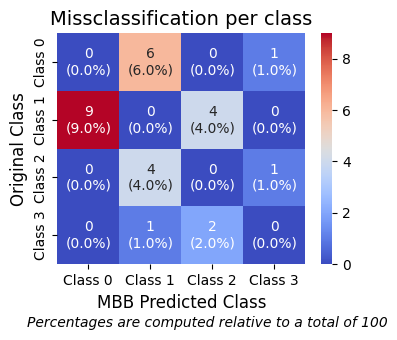



Test instances considered for following statistic: 72
 18 instances of class 0
 12 instances of class 1
 20 instances of class 2
 22 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 0/72  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 3 out of 3 counter-classes: 0  -- 0.00 %


Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1 Class 2 Class 3 Total  Perc
Class 0     0.0     0.0     0.0     0.0   0.0  nan%
Class 1     0.0     0.0     0.0     0.0   0.0  nan%
Class 2     0.0     0.0     0.0     0.0   0.0  nan%
Class 3     0.0     0.0     0.0     0.0   0.0  nan%
Total       0.0     0.0     0.0     0.0   0.0  nan%
Perc     

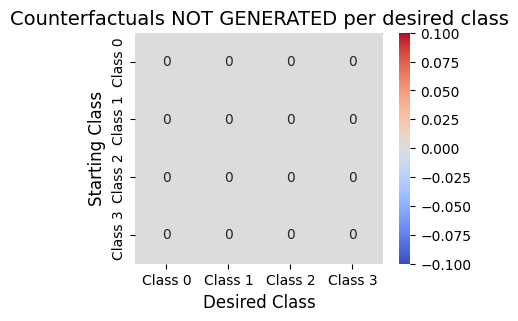





### COUNTERFACTUALS PRODUCED ###
Total counterfactuals produced: 648
Total counterfactuals not acceptable: 0 -- 0.00%
Total counterfactuals     acceptable: 648 -- 100.00% 
           Counterfactuals  specific: 648 -- 100.00%
           Counterfactuals plausible: 0 -- 0.00%


Avg. counterfactuals produced x instance: 9.00
    class '0' instances: 2.25 
    class '1' instances: 2.50 
    class '2' instances: 2.17 
    class '3' instances: 2.08 




Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival

(Starting Class -> Rows, ARRIVAL Class -> Columns)
        Class 0 Class 1 Class 2 Class 3  Total   Perc
Class 0     0.0     0.0     0.0     0.0    0.0  0.00%
Class 1     0.0     0.0     0.0     0.0    0.0  0.00%
Class 2     0.0     0.0     0.0     0.0    0.0  0.00%
Class 3     0.0     0.0     0.0     0.0    0.0  0.00%
Total       0.0     0.0     0.0     0.0    0.0  0.00%
Perc      0.00%   0.00%   0.00%   0.00%  0.00%      0


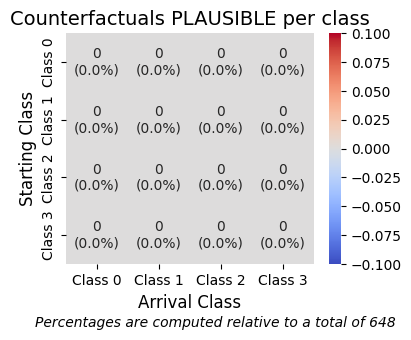

Avg. counterfactuals produced x instance: 0.00


Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : nan ± nan
Considering the 2 closest counterfactual : nan ± nan
Considering the 3 closest counterfactual : nan ± nan


Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)

(Starting Class -> Rows, Desired Class=Arrival Class -> Columns)
        Class 0 Class 1 Class 2 Class 3    Total     Perc
Class 0     0.0    54.0    54.0    54.0    162.0   25.00%
Class 1    36.0     0.0    36.0    36.0    108.0   16.67%
Class 2    60.0    60.0     0.0    60.0    180.0   27.78%
Class 3    66.0    66.0    66.0     0.0    198.0   30.56%
Total     162.0   180.0   156.0   150.0    648.0  100.00%
Perc     25.00%  27.78%  24.07%  23.15%  100.00%        0


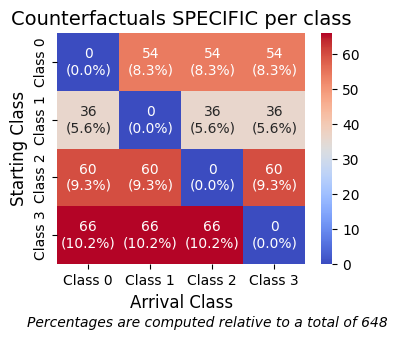

Avg. counterfactuals produced x instance: 9.00
    class '0' instances: 2.25 
    class '1' instances: 2.50 
    class '2' instances: 2.17 
    class '3' instances: 2.08 
Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 0.17 ± 0.12
Considering the 2 closest counterfactual : 0.25 ± 0.12
Considering the 3 closest counterfactual : 0.33 ± 0.14


Avg. Anomaly score on training set: 0.04 ± 0.04
Avg. Anomaly score on counterfactuals set: -0.01 ± 0.04
Metric for comparisons
On ONLY SPECIFIC
Avg. Anomaly score on training set: 0.04 ± 0.04
Avg. Anomaly score on counterfactuals set: -0.01 ± 0.04
 D_dist_(only first): 0.17 ± 0.12 
 D_dist_(all): 0.45 ± 0.22 
 D_count: 0.16 ± 0.04 
 D_plausibility: 0.29 ± 0.15 


Processing SPECIFIC cfs Robustness: Mean Absolute Deviation:   0%|          | 0/648 [00:00<?, ?it/s]

 (Drob1): 0.27 ± 0.31
 D_Robustness: 0.53 ± 0.26 


Processing DIVESITY cfs metric:   0%|          | 0/209628 [00:00<?, ?it/s]

 D_diversity_(dist): 0.84 ± 0.26
 D_diversity_(count): 0.89 ± 0.11


E.g id_test of not acceptable cf. []
E.g id_test of plausible cf. []
E.g id_test of specific cf. [ 1  2  4  5  6 10 11 13 14 16]


In [16]:
#change_f= [2,4,5,6,7,10]
change_f=list(range(3,X_train.shape[1]))
#change_f=list(range(5,X_train.shape[1]))
# change_f=list(range(X_train.shape[1])) # all feature can be changed
#perturbed_features=list(range(3,X_train.shape[1]-1)) # feature to be perturbed to compute robustness index
perturbed_features=change_f 

#list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_1V1(test_set,counterfactuals_set,res_set,train_set,change_f,max_f,bbox,perturbed_features)

In [ ]:
### Computing metrics values on other modalities (more simpler)

# 1vALL

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 100
Class labels: [0 1 2]
 33 instances of class 0
 33 instances of class 1
 34 instances of class 2
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['category_red' 'citric acid' 'fixed acidity' 'residual sugar'
 'volatile acidity']


Total correct classifications: 51 -- Accuracy: 51.00 %
Total miss_classifications: 49 / 100 49.00 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2   Total    Perc
Class 0     0.0    17.0     0.0    17.0  17.00%
Class 1     7.0     0.0     3.0    10.0  10.00%
Class 2     1.0    21.0     0.0    22.0  22.00%
Total       8.0    38.0     3.0    49.0  49.00%
Perc      8.00%  38.00%   3.00%  49.00%       0


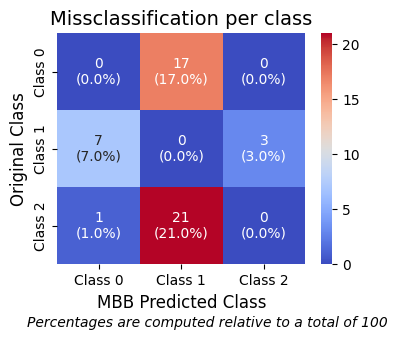



Test instances considered for following statistic: 51
 16 instances of class 0
 23 instances of class 1
 12 instances of class 2


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 2/51  -- 3.92 %
Total instances unable to generate a counterfactual for exactly 1 out of 2 counter-classes: 2  -- 3.92 %
Total instances unable to generate a counterfactual for exactly 2 out of 2 counter-classes: 0  -- 0.00 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1 Class 2 Total  Perc
Class 0     0.0     0.0     0.0   0.0  nan%
Class 1     0.0     0.0     0.0   0.0  nan%
Class 2     0.0     0.0     0.0   0.0  nan%
Total       0.0     0.0     0.0   0.0  nan%
Perc       nan%    nan%    nan%  nan%     0


### COUNTERFACTUALS PRODUCED ###
Total counterfactuals produced: 201
Total counterfactuals not acceptable: 60 -- 29.85%
Total counterfactuals     acceptable: 141 -- 70.15% 
           Cou

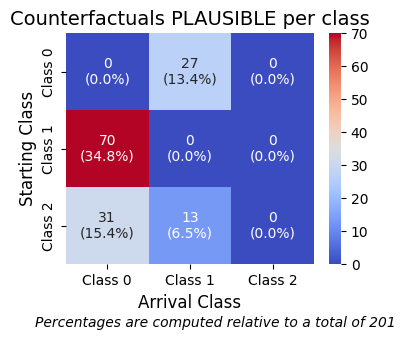

Class arrival 0 : 101.0  -> avg dist 0.87 ± 0.15
Class arrival 1 : 40.0  -> avg dist 0.59 ± 0.33
Class arrival 2 : 0.0  -> avg dist nan ± nan
Avg. counterfactuals produced x instance: 2.76
    class '0.0' instances: 1.98 
    class '1.0' instances: 0.78 


Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 0.54 ± 0.27
Considering the 2 closest counterfactual : 0.83 ± 0.14
Considering the 3 closest counterfactual : 0.93 ± 0.07


Avg. Anomaly score on training set: 0.05 ± 0.04
Avg. Anomaly score on counterfactuals set: -0.03 ± 0.04


E.g id_test of not acceptable cf. [ 1  2  4  5  6 14 16 22 24 27]
E.g id_test of plausible cf. [ 1  2  6  7 10 11 12 14 15 16]
E.g id_test of specific cf. []


In [58]:
#train_set=pd.read_csv(DS_PATH+"K_EMOCON/SUB_5/sub_5_train2.csv")
train_set=pd.read_csv(DS_PATH+"Wine/wine_train2.csv")
# test_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_9/SVM2/testset_t1vAll.csv")
# counterfactuals_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_9/SVM2/counterfactualset_t1vAll.csv")
# res_set=pd.read_csv(PATH_TESTS+"K_EMOCON/SUB_9/SVM2/results_t1vAll.csv")

test_set=pd.read_csv(PATH_TESTS+"Wine/SVM7/testset_t1vAll.csv")
counterfactuals_set=pd.read_csv(PATH_TESTS+"Wine/SVM7/counterfactualset_t1vAll.csv")
res_set=pd.read_csv(PATH_TESTS+"Wine/SVM7/results_t1vAll.csv")

change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_1VALL(test_set,counterfactuals_set,res_set,train_set,change_f,max_f)

0      False
1      False
2      False
3      False
4      False
       ...  
309    False
310    False
311    False
312    False
313    False
Length: 268, dtype: bool

In [47]:
total_counter_plausible[(working_res_set_aligned["mbbox_counter_class_pred"] == 2) & 
                pd.notna(working_res_set_aligned["ID_COUNTER"])].shape[0]
#.groupby("mbbox_counter_class_pred")["counter_distance"]

56

array([0., 0., 0., 0.])

# 1vALL_Spec

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 1000
Class labels: [0 1 2 3]
 250 instances of class 0
 250 instances of class 1
 250 instances of class 2
 250 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['age' 'gender_F' 'gender_M' 'height_cm' 'weight_kg']


Total correct classifications: 738 -- Accuracy: 73.80 %
Total miss_classifications: 262 / 1000 26.20 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    31.0     1.0     0.0    32.0   3.20%
Class 1    60.0     0.0    32.0    13.0   105.0  10.50%
Class 2    16.0    49.0     0.0    16.0    81.0   8.10%
Class 3     6.0    12.0    26.0     0.0    44.0   4.40%
Total      82.0    92.0    59.0    29.0   262.0  26.20%
Perc      8.20%   9.20%   5.90%   2.90%  26.20%       0


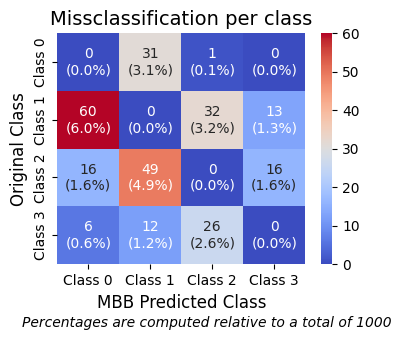



Test instances considered for following statistic: 738
 218 instances of class 0
 145 instances of class 1
 169 instances of class 2
 206 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 59/738  -- 7.99 %
Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 59  -- 7.99 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 3 out of 3 counter-classes: 0  -- 0.00 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1 Class 2 Class 3 Total  Perc
Class 0     0.0     0.0     0.0     0.0   0.0  nan%
Class 1     0.0     0.0     0.0     0.0   0.0  nan%
Class 2     0.0     0.0     0.0     0.0   0.0  nan%
Class 3     0.0     0.0     0.0     0.0   0.0  nan%
Total       0.0     0.0     0.0     0.0   0.0  nan%
Per

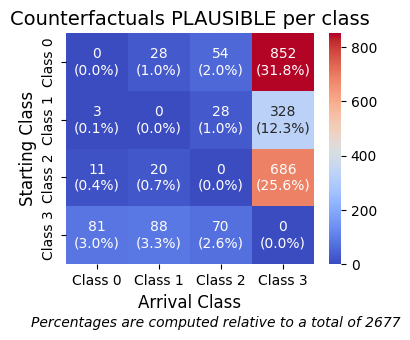

Class arrival 0 : 95.0  -> avg dist 77.11 ± 29.80
Class arrival 1 : 136.0  -> avg dist 64.77 ± 39.27
Class arrival 2 : 152.0  -> avg dist 73.56 ± 44.29
Class arrival 3 : 1866.0  -> avg dist 52.65 ± 40.00
Avg. counterfactuals produced x instance: 3.05
    class '0.0' instances: 0.13 
    class '1.0' instances: 0.18 
    class '2.0' instances: 0.21 
    class '3.0' instances: 2.53 


Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 29.06 ± 23.43
Considering the 2 closest counterfactual : 45.30 ± 25.28
Considering the 3 closest counterfactual : 62.26 ± 32.39


Avg. Anomaly score on training set: 0.07 ± 0.05


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age
- body fat_%
- broad jump_cm
- diastolic
- gender_F
- ...
Feature names seen at fit time, yet now missing:
- Attention
- E4-BVP
- E4-EDA
- E4-HR
- E4-IBI
- ...


In [15]:
# test_set=pd.read_csv("./tests/testset_t1vAll_Spec.csv")
# counterfactuals_set=pd.read_csv("./tests/counterfactualset_t1vAll_Spec.csv")
# res_set=pd.read_csv("./tests/results_t1vAll_Spec.csv")

test_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/testset_t1vAll_Spec.csv")
counterfactuals_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/counterfactualset_t1vAll_Spec.csv")
res_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/results_t1vAll_Spec.csv")

change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_1VALL(test_set,counterfactuals_set,res_set,train_set,change_f,max_f)

# ALLv1

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 1000
Class labels: [0 1 2 3]
 250 instances of class 0
 250 instances of class 1
 250 instances of class 2
 250 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['age' 'gender_F' 'gender_M' 'height_cm' 'weight_kg']


Total correct classifications: 738 -- Accuracy: 73.80 %
Total miss_classifications: 262 / 1000 26.20 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    31.0     1.0     0.0    32.0   3.20%
Class 1    60.0     0.0    32.0    13.0   105.0  10.50%
Class 2    16.0    49.0     0.0    16.0    81.0   8.10%
Class 3     6.0    12.0    26.0     0.0    44.0   4.40%
Total      82.0    92.0    59.0    29.0   262.0  26.20%
Perc      8.20%   9.20%   5.90%   2.90%  26.20%       0


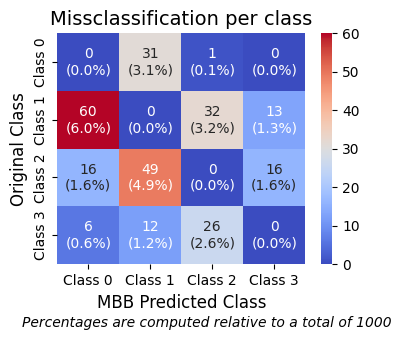



Test instances considered for following statistic: 738
 218 instances of class 0
 145 instances of class 1
 169 instances of class 2
 206 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 34/738  -- 4.61 %
Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 34  -- 4.61 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 3 out of 3 counter-classes: 0  -- 0.00 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1  Class 2 Class 3    Total     Perc
Class 0     0.0     0.0     27.0     0.0     27.0   79.41%
Class 1     0.0     0.0      3.0     0.0      3.0    8.82%
Class 2     0.0     0.0      0.0     0.0      0.0    0.00%
Class 3     0.0     0.0      4.0     0.0      4.0   11.76%
Total       0.0     

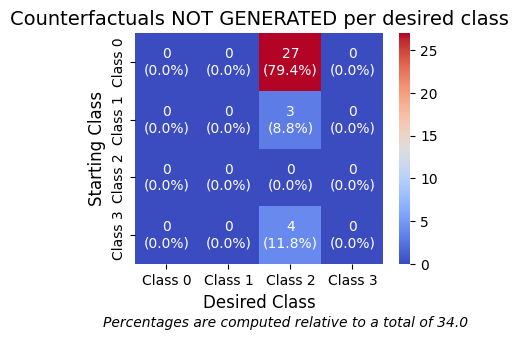





### COUNTERFACTUALS PRODUCED ###
Total counterfactuals produced: 11276
Total counterfactuals not acceptable: 4622 -- 40.99%
Total counterfactuals     acceptable: 6654 -- 59.01% 
           Counterfactuals  specific: 5493 -- 48.71%
           Counterfactuals plausible: 1161 -- 10.30%


Avg. counterfactuals produced x instance: 15.28
    class '0' instances: 1.29 
    class '1' instances: 3.28 
    class '2' instances: 2.69 
    class '3' instances: 8.03 




Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival

(Starting Class -> Rows, ARRIVAL Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0   141.0   118.0    23.0   282.0   2.50%
Class 1    57.0     0.0   218.0    17.0   292.0   2.59%
Class 2    86.0    83.0     0.0    17.0   186.0   1.65%
Class 3   155.0   106.0   140.0     0.0   401.0   3.56%
Total     298.0   330.0   476.0    57.0  1161.0  10.30%
Perc      2.64%   2.93%   4.22%   0.51%  10.30%       0


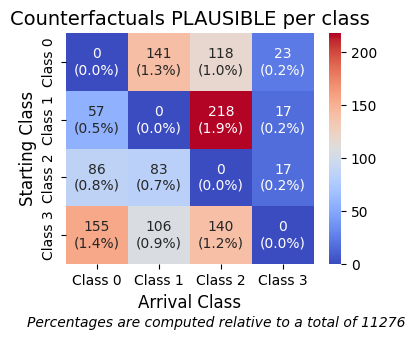

Avg. counterfactuals produced x instance: 1.57
    class '0.0' instances: 0.40 
    class '1.0' instances: 0.45 
    class '2.0' instances: 0.64 
    class '3.0' instances: 0.08 


Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 96.55 ± 61.24
Considering the 2 closest counterfactual : 143.77 ± 56.69
Considering the 3 closest counterfactual : 158.14 ± 47.53


Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)

(Starting Class -> Rows, Desired Class=Arrival Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    30.0    65.0  2046.0  2141.0  18.99%
Class 1   141.0     0.0   109.0  1206.0  1456.0  12.91%
Class 2   145.0   153.0     0.0  1058.0  1356.0  12.03%
Class 3   174.0   124.0   242.0     0.0   540.0   4.79%
Total     460.0   307.0   416.0  4310.0  5493.0  48.71%
Perc      4.08%   2.72%   3.69%  38.22%  48.71%       0


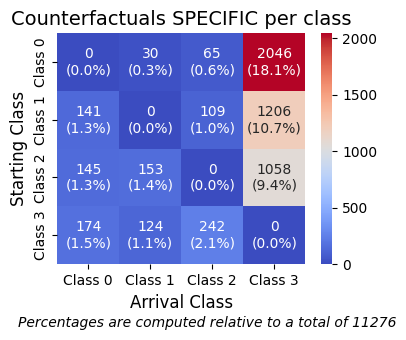

Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 44.90 ± 37.15
Considering the 2 closest counterfactual : 56.23 ± 41.47
Considering the 3 closest counterfactual : 57.21 ± 36.94
Avg. proximity SPECIFIC counterfactual distance
Considering the 1 closest counterfactuals : 44.90
Considering the 2 closest counterfactuals : 56.23
Considering the 3 closest counterfactuals : 57.21


E.g id_test of not acceptable cf. [ 1  3  5  6  8 10 13 14 16 17]
E.g id_test of plausible cf. [ 1  3  5  6  8 10 13 16 17 18]
E.g id_test of specific cf. [ 1  3  5  6  8 10 13 14 16 17]


In [23]:
# test_set=pd.read_csv("./tests/testset_tAll_v1.csv")
# counterfactuals_set=pd.read_csv("./tests/counterfactualset_tAll_v1.csv")
# res_set=pd.read_csv("./tests/results_tAll_v1.csv")

test_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/testset_tAll_v1.csv")
counterfactuals_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/counterfactualset_tAll_v1.csv")
res_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/results_tAll_v1.csv")

change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_ALLV1(test_set,counterfactuals_set,res_set,change_f,max_f)

# ALL_Spec v 1

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 1000
Class labels: [0 1 2 3]
 250 instances of class 0
 250 instances of class 1
 250 instances of class 2
 250 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['age' 'gender_F' 'gender_M' 'height_cm' 'weight_kg']


Total correct classifications: 738 -- Accuracy: 73.80 %
Total miss_classifications: 262 / 1000 26.20 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    31.0     1.0     0.0    32.0   3.20%
Class 1    60.0     0.0    32.0    13.0   105.0  10.50%
Class 2    16.0    49.0     0.0    16.0    81.0   8.10%
Class 3     6.0    12.0    26.0     0.0    44.0   4.40%
Total      82.0    92.0    59.0    29.0   262.0  26.20%
Perc      8.20%   9.20%   5.90%   2.90%  26.20%       0


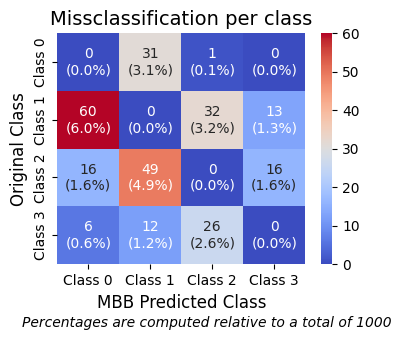



Test instances considered for following statistic: 738
 218 instances of class 0
 145 instances of class 1
 169 instances of class 2
 206 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 124/738  -- 16.80 %
Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 124  -- 16.80 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfactual for exactly 3 out of 3 counter-classes: 0  -- 0.00 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
         Class 0 Class 1 Class 2 Class 3    Total     Perc
Class 0      0.0     0.0     0.0     0.0      0.0    0.00%
Class 1      0.0     0.0     0.0     0.0      0.0    0.00%
Class 2     21.0     0.0     0.0     0.0     21.0   16.94%
Class 3    103.0     0.0     0.0     0.0    103.0   83.06%
Total      124.0

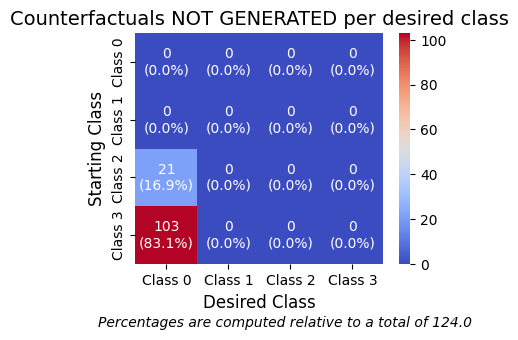





### COUNTERFACTUALS PRODUCED ###
Total counterfactuals produced: 11383
Total counterfactuals not acceptable: 5941 -- 52.19%
Total counterfactuals     acceptable: 5442 -- 47.81% 
           Counterfactuals  specific: 3833 -- 33.67%
           Counterfactuals plausible: 1609 -- 14.14%


Avg. counterfactuals produced x instance: 15.42
    class '0' instances: 1.41 
    class '1' instances: 3.27 
    class '2' instances: 3.72 
    class '3' instances: 7.03 




Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival

(Starting Class -> Rows, ARRIVAL Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0   199.0   150.0    82.0   431.0   3.79%
Class 1   116.0     0.0   272.0    30.0   418.0   3.67%
Class 2    81.0   160.0     0.0    40.0   281.0   2.47%
Class 3   140.0   178.0   161.0     0.0   479.0   4.21%
Total     337.0   537.0   583.0   152.0  1609.0  14.14%
Perc      2.96%   4.72%   5.12%   1.34%  14.14%       0


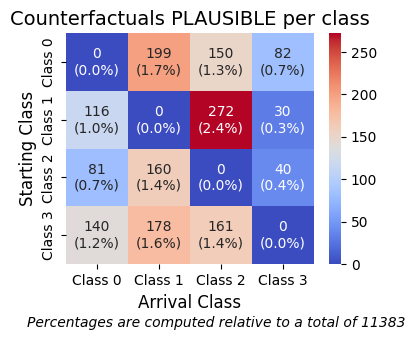

Avg. counterfactuals produced x instance: 2.18
    class '0.0' instances: 0.46 
    class '1.0' instances: 0.73 
    class '2.0' instances: 0.79 
    class '3.0' instances: 0.21 


Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 78.68 ± 58.24
Considering the 2 closest counterfactual : 123.40 ± 62.66
Considering the 3 closest counterfactual : 142.74 ± 53.20


Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)

(Starting Class -> Rows, Desired Class=Arrival Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    12.0    70.0  1414.0  1496.0  13.14%
Class 1   195.0     0.0   111.0   903.0  1209.0  10.62%
Class 2    93.0    79.0     0.0   715.0   887.0   7.79%
Class 3    26.0    65.0   150.0     0.0   241.0   2.12%
Total     314.0   156.0   331.0  3032.0  3833.0  33.67%
Perc      2.76%   1.37%   2.91%  26.64%  33.67%       0


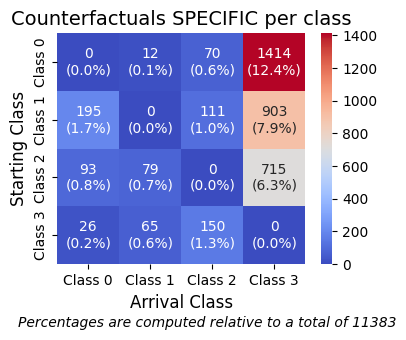

Avg. Proximity Distance from the Nth closest cf.
Considering the 1 closest counterfactual : 43.54 ± 32.04
Considering the 2 closest counterfactual : 48.89 ± 27.82
Considering the 3 closest counterfactual : 52.01 ± 25.85
Avg. proximity SPECIFIC counterfactual distance
Considering the 1 closest counterfactuals : 43.54
Considering the 2 closest counterfactuals : 48.89
Considering the 3 closest counterfactuals : 52.01


E.g id_test of not acceptable cf. [ 1  3  5  6  8 10 13 14 16 17]
E.g id_test of plausible cf. [ 1  3  5  6  8 10 13 16 17 18]
E.g id_test of specific cf. [ 1  3  5  6  8 10 13 14 16 17]


In [22]:
# test_set=pd.read_csv("./tests/testset_tAll_Specv1.csv")
# counterfactuals_set=pd.read_csv("./tests/counterfactualset_tAll_Specv1.csv")
# res_set=pd.read_csv("./tests/results_tAll_Specv1.csv")

test_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/testset_tAll_Specv1.csv")
counterfactuals_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/counterfactualset_tAll_Specv1.csv")
res_set=pd.read_csv(PATH_TESTS+"BodyPerformance/XGB_orig/results_tAll_Specv1.csv")

change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_ALLV1(test_set,counterfactuals_set,res_set,change_f,max_f)

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 100
Class labels: [0 1 2 3]
 25 instances of class 0
 25 instances of class 1
 25 instances of class 2
 25 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['age' 'gender_F' 'gender_M' 'height_cm' 'weight_kg']


Total correct classifications: 71 -- Accuracy: 71.00 %
Total miss_classifications: 29 / 100 29.00 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0     5.0     0.0     0.0     5.0   5.00%
Class 1     7.0     0.0     5.0     2.0    14.0  14.00%
Class 2     2.0     2.0     0.0     3.0     7.0   7.00%
Class 3     0.0     1.0     2.0     0.0     3.0   3.00%
Total       9.0     8.0     7.0     5.0    29.0  29.00%
Perc      9.00%   8.00%   7.00%   5.00%  29.00%       0


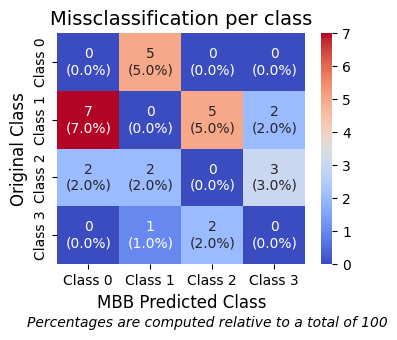



Test instances considered for following statistic: 71
 20 instances of class 0
 11 instances of class 1
 18 instances of class 2
 22 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 12/71  -- 16.90 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0     0.0     0.0     0.0     0.0   0.00%
Class 1     0.0     0.0     0.0     0.0     0.0   0.00%
Class 2     0.0     1.0     0.0     0.0     1.0   1.41%
Class 3     0.0     3.0     8.0     0.0    11.0  15.49%
Total       0.0     4.0     8.0     0.0    12.0  16.90%
Perc      0.00%   5.63%  11.27%   0.00%  16.90%       0


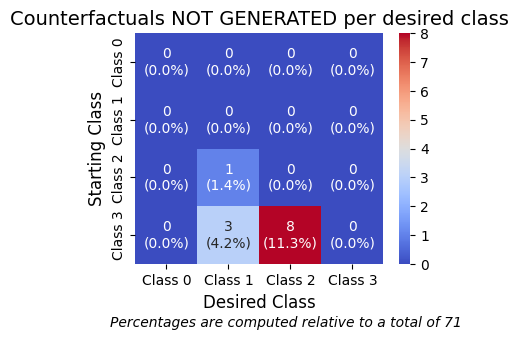



Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 9  -- 12.68 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 3  -- 4.23 %
Total instances unable to generate a counterfactual for exactly 3 out of 3 counter-classes: 0  -- 0.00 %


### COUNTERFACTUALS PRODUCED ###
Total counterfactuals produced: 925
Total counterfactuals not acceptable: 101 -- 10.92%
Total counterfactuals     acceptable: 824 -- 89.08% 
           Counterfactuals  specific: 375 -- 40.54%
           Counterfactuals plausible: 449 -- 48.54%


Avg. counterfactuals produced x instance: 13.03
    class '0' instances: 2.56 
    class '1' instances: 2.72 
    class '2' instances: 4.85 
    class '3' instances: 2.90 




Counterfactuals PLAUSIBLE per class (Starting_Class!=Arrival_Class) Plot Class Arrival

(Starting Class -> Rows, ARRIVAL Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    18.0    44

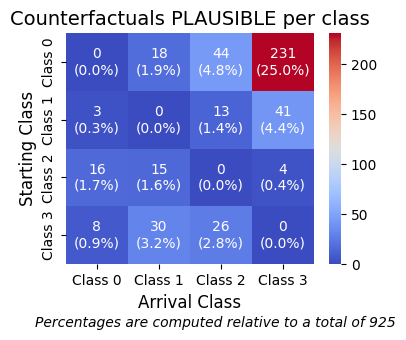

Avg. counterfactuals produced x instance: 6.51
    class '0.0' instances: 0.38 
    class '1.0' instances: 0.89 
    class '2.0' instances: 1.17 
    class '3.0' instances: 3.89 


Avg. proximity PLAUSIBLE counterfactual distance
Considering the 1 closest counterfactuals : 63.01
Considering the 2 closest counterfactuals : 75.00
Considering the 3 closest counterfactuals : 81.89


Counterfactuals SPECIFIC per class (Desired Class=Arrival Class)

(Starting Class -> Rows, Desired Class=Arrival Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0    13.0    20.0    99.0   132.0  14.27%
Class 1    33.0     0.0    16.0    22.0    71.0   7.68%
Class 2    51.0    31.0     0.0    41.0   123.0  13.30%
Class 3    28.0    11.0    10.0     0.0    49.0   5.30%
Total     112.0    55.0    46.0   162.0   375.0  40.54%
Perc     12.11%   5.95%   4.97%  17.51%  40.54%       0


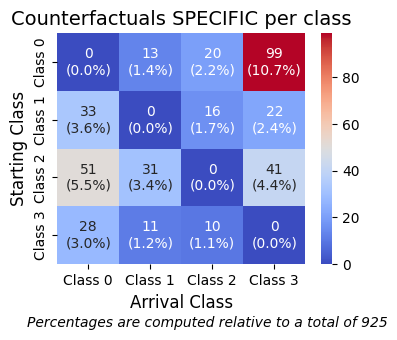

Avg. counterfactuals produced x instance: 5.28
    class '0' instances: 1.58 
    class '1' instances: 0.77 
    class '2' instances: 0.65 
    class '3' instances: 2.28 
Avg. proximity SPECIFIC counterfactual distance
Considering the 1 closest counterfactuals : 49.96
Considering the 2 closest counterfactuals : 60.72
Considering the 3 closest counterfactuals : 68.37


E.g id_test of not acceptable cf. [ 2  6  7 11 15 16 19 22 25 27]
E.g id_test of plausible cf. [ 1  2  3  5  6  7 10 11 13 14]
E.g id_test of specific cf. [ 1  2  3  5  6  7 10 11 13 14]


In [52]:
test_set=pd.read_csv("./tests/testset_1_v_1.csv")
counterfactuals_set=pd.read_csv("./tests/counterfactualset_1_v_1.csv")
res_set=pd.read_csv("./tests/results_1_v_1.csv")
change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_1V1(test_set,counterfactuals_set,res_set,change_f,max_f)

### Statistic results ###


### TEST INSTANCES ###
Total test instances: 100
Class labels: [0 1 2 3]
 25 instances of class 0
 25 instances of class 1
 25 instances of class 2
 25 instances of class 3
Total number of attributes: 12
Max number of changeble attributes: 7
Attributes that have been left fixed: ['age' 'gender_F' 'gender_M' 'height_cm' 'weight_kg']


Total correct classifications: 71 -- Accuracy: 71.00 %
Total miss_classifications: 29 / 100 29.00 %
Missclassification per class

(Original Class -> Rows, MBB Predicted Class -> Columns)
        Class 0 Class 1 Class 2 Class 3   Total    Perc
Class 0     0.0     5.0     0.0     0.0     5.0   5.00%
Class 1     7.0     0.0     5.0     2.0    14.0  14.00%
Class 2     2.0     2.0     0.0     3.0     7.0   7.00%
Class 3     0.0     1.0     2.0     0.0     3.0   3.00%
Total       9.0     8.0     7.0     5.0    29.0  29.00%
Perc      9.00%   8.00%   7.00%   5.00%  29.00%       0


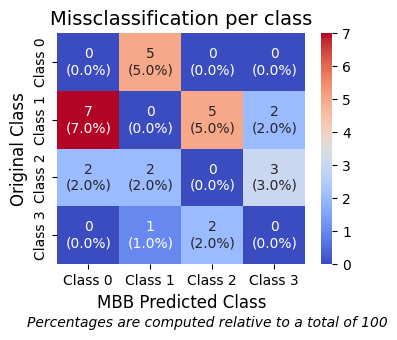



Test instances considered for following statistic: 71
 20 instances of class 0
 11 instances of class 1
 18 instances of class 2
 22 instances of class 3


Total instances NOT CAPABLE to generate at least a counterfactual for a specific class: 4/71  -- 5.63 %
Counterfactuals NOT GENERATED per desired class

(Starting Class -> Rows, Desired Class -> Columns)
        Class 0 Class 1 Class 2 Class 3  Total   Perc
Class 0     0.0     0.0     0.0     0.0    0.0  0.00%
Class 1     0.0     0.0     0.0     0.0    0.0  0.00%
Class 2     0.0     0.0     0.0     0.0    0.0  0.00%
Class 3     0.0     0.0     0.0     0.0    0.0  0.00%
Total       0.0     0.0     0.0     0.0    0.0  0.00%
Perc      0.00%   0.00%   0.00%   0.00%  0.00%      0


Total instances unable to generate a counterfactual for exactly 1 out of 3 counter-classes: 4  -- 5.63 %
Total instances unable to generate a counterfactual for exactly 2 out of 3 counter-classes: 0  -- 0.00 %
Total instances unable to generate a counterfact

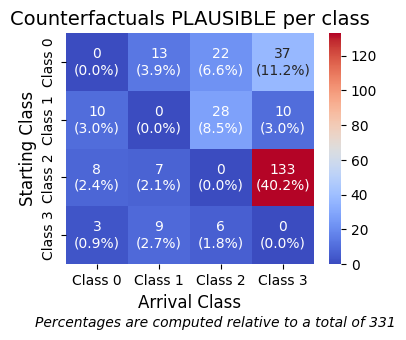

Avg. counterfactuals produced x instance: 4.03
    class '0.0' instances: 0.30 
    class '1.0' instances: 0.41 
    class '2.0' instances: 0.79 
    class '3.0' instances: 2.54 


Avg. proximity PLAUSIBLE counterfactual distance
Considering the 1 closest counterfactuals : 35.49
Considering the 2 closest counterfactuals : 41.88
Considering the 3 closest counterfactuals : 56.33


E.g id_test of not acceptable cf. [ 1  5  7 10 15 16 25 27 30 32]
E.g id_test of plausible cf. [ 1  2  3  5  6  7 10 11 13 14]
E.g id_test of specific cf. []


In [53]:
test_set=pd.read_csv("./tests/testset_t1vAll.csv")
counterfactuals_set=pd.read_csv("./tests/counterfactualset_t1vAll.csv")
res_set=pd.read_csv("./tests/results_t1vAll.csv")
change_f=list(range(5,test_set.shape[1]))
max_f=len(change_f)
          
print_statistics_1VALL(test_set,counterfactuals_set,res_set,change_f,max_f)